# Predicting Critical Health and Safety Violations at Food Establishments
<p><em>Prepared by Geovanna Meier</em></p>

<p>As a destination that attracts millions of tourists every year, Southern Nevada, and particularly Las Vegas, offers many possibilities when it comes to dining options. With food offerings that range from small locales to Michelin star restaurants, the choices may seem endless. Although this may be a great experience for visitors, it can become a challenging task for the Southern Nevada Health District, who must inspect every food establishment to ensure that it meets the food and safety requirements to protect public’s health.
</p>

<p>Hence, the goal of this analysis is to use publicly available data from restaurant inspection results from the Southern Nevada Health District and Yelp’s data on businesses and consumers’ ratings, to predict non-compliant results and help optimize and prioritize inspection visits. The assumption is that inspection results may differ based on the type, date, and time of the inspection, establishment's cuisine type, business ratings, and the number of review it has received.</p>

<p>Thus, the null hypothesis is that holding everything else constant, the probability that a restaurant receives a passing grade is the same for all restaurants, independent of the month the inspection takes place, the location, restaurant's attributes, their Yelp's stars ratings, business ratings, review counts, type of food, or review counts. The alternative hypothesis is that there is a statistically significant difference between the attributes of a restaurant that have passing grades and those with downgrades.</p>

#### Data Sources:
* [Southern Nevada Health District Restaurant Inspections](https://opendata.lasvegasnevada.gov/API-Integration-/Restaurant-Inspections/q8ye-5kwk)
* [Business and Reviews Yelp Academic Datasets](https://www.yelp.com/dataset)
***
<p><b><em>Skills:</em></b> API, JSON, EDA, Inferential Statistics, Machine Learning.</p>
<p><b><em>Libraries:</em></b> Pandas, NumPy, Requests, Matplotlib, Seaborn, Scikit-learn.</p>

***
# Contents
* [Set Up Enviroment](#environment)
* [Set Files Path](#filepath)
* [Collecting Inspections Data](#inspectionsdata)
* [Data Wrangling](#datawrangling)
* [EDA and Inferential Statistics Inspections](#EDAinspections)
* [Collect Yelp Academic Files](#yelpdata)
* [Merge Inspection Results and Yelp Data](#mergealldata)
* [EDA Complete Dataset](#EDAcompletedata)
* [Correlations](#correlations)
* [Machine Learning](#predictivemodels)
    * [Logistic Regression](#logistic)
    * [Random Forest](#randomforest)
* [Results and Conclusions](#conclusions)

<a id='environment'></a>

****

# Set up the Enviroment

In [1]:
# set filterwarnings to 'once' to show warnings only the first time code is run
import warnings
warnings.filterwarnings('once') # show warnings only the first time code is run

# pretty print all cell's output and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# import necessary modules for analysis
import pandas as pd
from pandas.io.json import json_normalize
import json
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
import re
import numpy as np


# set jupyter enviroment
plt.rcParams['figure.figsize'] = [12,6]
plt.style.use(['fivethirtyeight'])
#plt.style.use('Solarize_Light2')
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
sns.set_style(style = 'darkgrid')
pd.set_option('display.max_columns',5000)
pd.set_option('display.max_rows', 5000)

In [3]:
# import modules for modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report

<a id='filepath'></a>

## Set File Path

In [4]:
# set up file paths where files are located
pc_path = 'C:/SET_YOUR_PATH'
mac_path = '/SET_YOUR_PATH'

In [5]:
# save files locally
def file_path(machine):
    if machine == 'mac':
        path = mac_path
    else:
        path = pc_path
    return path

### Set Path for Windows or Mac

In [6]:
path = file_path(machine = 'mac')

<a id='inspectionsdata'></a>

****
# Collect Restaurant Inspections Data Using API

In [7]:
%time
# get the url to collect the data
url = 'https://opendata.lasvegasnevada.gov/resource/86jg-3buh.json?$limit=170000'#168161'

# package the request, send the request and catch the response
r = requests.get(url)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [8]:
# get the text from the url
txt = r.text

# look at the structure
print(type(txt))
print(len(txt))   # get an idea of how long is the text before displaying it
print(txt[:20])

<class 'str'>
122148959
[{"address":"4000 W 


In [9]:
%time
# convert the text into json file
json_file = r.json()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


In [10]:
# look at the type and structure
print(len(json_file))
print(type(json_file))
print(json_file[0])

170000
<class 'list'>
{'address': '4000 W Flamingo Rd', 'category_name': 'Bar / Tavern', 'city': 'Las Vegas', 'current_demerits': '5', 'current_grade': 'A', 'date_current': '2017-08-07T00:00:00.000', 'employee_id': 'EE7001214', 'inspection_date': '2017-08-07T00:00:00.000', 'inspection_demerits': '5', 'inspection_grade': 'A', 'inspection_result': "'A' Grade", 'inspection_time': '2017-08-07T15:20:00.000', 'inspection_type': 'Routine Inspection', 'location_1': {'type': 'Point', 'coordinates': [115.1929046, 36.1166353]}, 'location_name': 'Gold Coast Hotel & Casino', 'permit_number': 'PR0006774', 'permit_status': 'A', 'record_updated': '2017-08-08T09:31:16.000', 'restaurant_name': 'Gold Coast Bingo Service Bar', 'serial_number': 'DA0EHXVCT', 'state': 'Nevada', 'violations': '209', 'zip': '89103-4004'}


In [11]:
# since it's a list of dictionaries, use normalization to change the data structure into a flat table
data = json_normalize(json_file)

In [12]:
# confirm file was loaded and look at the dataframe structure
print(data.shape)
data.head(2)

(170000, 25)


,:@computed_region_tnyv_z3b7,address,category_name,city,current_demerits,current_grade,date_current,employee_id,inspection_date,inspection_demerits,inspection_grade,inspection_result,inspection_time,inspection_type,location_1.coordinates,location_1.type,location_name,permit_number,permit_status,record_updated,restaurant_name,serial_number,state,violations,zip
0,NaN,4000 W Flamingo Rd,Bar / Tavern,Las Vegas,5,A,2017-08-07T00:00:00.000,EE7001214,2017-08-07T00:00:00.000,5,A,'A' Grade,2017-08-07T15:20:00.000,Routine Inspection,"[115.1929046, 36.1166353]",Point,Gold Coast Hotel & Casino,PR0006774,A,2017-08-08T09:31:16.000,Gold Coast Bingo Service Bar,DA0EHXVCT,Nevada,209,89103-4004
1,NaN,1237 Nevada Hwy,Restaurant,Boulder City,5,A,2017-08-08T00:00:00.000,EE7001020,2017-08-08T00:00:00.000,5,A,'A' Grade,2017-08-08T08:00:00.000,Routine Inspection,"[114.8491471, 35.9716148]",Point,McDonald's Restaurant,PR0002776,A,2017-08-08T08:52:21.000,McDonald's Restaurant #7790,DA0J0HTDI,Nevada,"202,2927",89005-1809


In [13]:
# remove leading and trailing spaces from the column names 
data.columns = data.columns.str.rstrip('')

In [14]:
# subset the dataset to relevant columns
nv = data.copy()[['address', 'category_name', 'city', 'current_demerits', 'current_grade','employee_id','inspection_date','inspection_demerits','inspection_grade',
                  'inspection_result','inspection_time','inspection_type','location_name','permit_status','restaurant_name','violations','zip','location_1.coordinates']]

# include only inspection from 2010 - 2018
nv = nv[nv['inspection_date']<'2019'].copy()

In [15]:
# review the number of missing values
nv.isna().sum()

address                       63
category_name                  0
city                          18
current_demerits               0
current_grade                 28
employee_id                    0
inspection_date                0
inspection_demerits            0
inspection_grade            1700
inspection_result              0
inspection_time               49
inspection_type                0
location_name                 10
permit_status             130057
restaurant_name                3
violations                 39617
zip                           19
location_1.coordinates         0
dtype: int64

In [16]:
# remove permit statust due to the high number of NAs
nv.drop('permit_status', axis = 1, inplace = True)

<a id='datawrangling'></a>

***
# Data Wrangling

In [17]:
# define functions to clean datasets

def col_cleanup(df, cols_list= None):
    """Returns column values in lower case
     a copy of the string with the leading and trailing characters removed."""
    for i in cols_list:
        df[i] = df[i].str.lower()
    df.columns = [x.rstrip('') for x in df.columns]
    return df

#remove special characters from name
def rm_special_char(column):
    """ Find and remove special characters and spaces from defined column """
    pattern1 = re.compile(r'\#\d*')
    pattern2 = re.compile(r'[a-z]')
    try:
        if pattern2.match(column):
            y = re.findall(pattern = pattern1,string = column)[0]
            return column.replace(y,"").strip(" ")
        else:
            return column
    except:
        return column
    
# create a separate column for year month, and day of the year.
def split_dates(df, col_date = None):
    """Split date to do the merge"""
    df[col_date] = pd.to_datetime(df[col_date])
    df['year_str'] = df[col_date].dt.year
    df['month_str'] = df[col_date].dt.month
    df['day_str']=df[col_date].dt.day_name()
    return df

# based on inspection results create the target variable
def target(df):
    """Use conditional statement to create target variable"""
    if df['inspection_result'] == "compliant":
        return int(1)
    elif df['inspection_result'] == "'a' grade":
        return int(1)
    elif df['inspection_result'] == 'approved':
        return int(1)
    elif df['inspection_result'] == "no further action":
        return int(1)
    elif df['inspection_result'] == 'unspecified' and df['inspection_grade'] == 'A':#and df['current_grade'] == 'A':
        return int(1)
    else:
        return int(0)

## Cleaning and Feature Engineering Inspection Data

In [18]:
#remove spaces from a list of columns
nv = col_cleanup(nv, cols_list= ['address', 'restaurant_name','inspection_result'])

# create a clean_name with special characters removed from restaurant name
nv['clean_name']= rm_special_char(nv['restaurant_name'])

# create month and year columns using the split_dates function
nv = split_dates(nv, col_date = 'inspection_date')

# create a zip-code column with the first part of the zip column 
nv['zip_code'] = nv['zip'].str.split('-').str[0]

# apply target function to creat the target variable
nv['is_compliant'] = nv.apply (lambda df: target (df),axis=1)

# convert the inspection time into datetime object and get only the tme
nv['inspection_time'] = pd.to_datetime(nv['inspection_time'])

# create a new varaible for the shift of inspections
nv["inspection_shift"] = ['morning' if x <= 12 else 'afternoon' for x in nv['inspection_time'].dt.hour]


<a id='EDAinspections'></a>

***
# EDA and Inferential Statistics

## Inspection Results Frequency
<p>The first step was to look at the distribution of inspection results from the original data to compare the proportion of compliant vs. non-complaint establishments and see how well food establishments do when it comes to safety and hygiene. A visualization of the number of inspections by inspection results, shows that over 80% of inspections result in a passing grade with only less than 20% having downgrades or critical violations. In fact, a histogram showing the total number of violations, shows that the most inspections have less than 10 violations.</p>

In [19]:
# create a new feature with count of violations per inspection visit
# split the violation codes into separate columns
violations = nv['violations'].str.split(',', expand=True)
# create a new column with the total number of codes per row
violations['violations_count'] = violations.count(axis = 1)
# fill the NAs and take only the counts column
violations = violations.fillna(0)
violations_count = violations[['violations_count']]
# join the main dataset with the violations
nv = pd.concat([nv, violations_count], axis=1)

Proportion of compliance: 0.8799



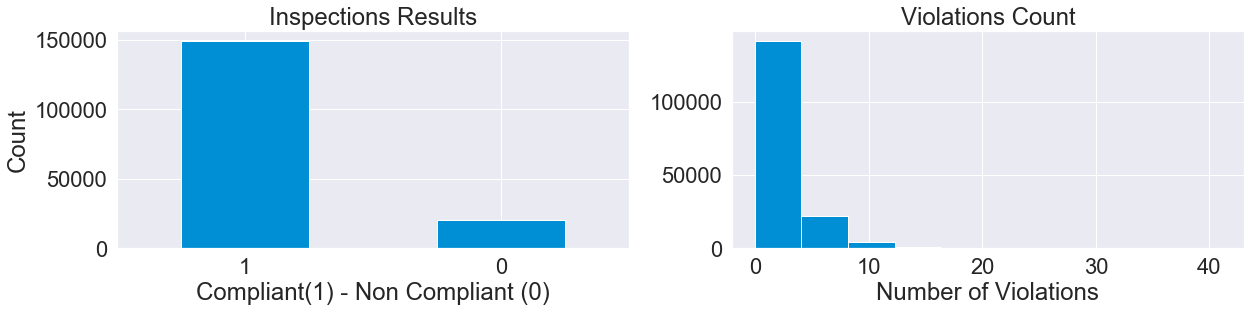

In [20]:
# plot inspection results distribution and violation counts
plt.rcParams['figure.figsize'] = [18,4]

# plot the distribution of inspection results
_=plt.subplot(1,2,1)
_=nv['is_compliant'].value_counts().plot(kind = 'bar', rot = 0)
_=plt.title('Inspections Results')
_=plt.ylabel('Count')
_=plt.xlabel('Compliant(1) - Non Compliant (0)')

_=plt.subplot(1,2,2)
_=plt.hist(nv['violations_count'])
_=plt.xlabel('Number of Violations')
_=plt.title('Violations Count')

# proportion of compliance
yes = np.sum(nv['is_compliant'])
print('Proportion of compliance:', np.round((yes/len(nv)),4),end='\n\n')

### Are inspections evenly distributed among inspectors?
<p>A close analysis to the number of visits done by employee ID, shows that in 2018, a few number of inspectors had a large number of inspections, with a single employee having over 550 recorded visits.</p>

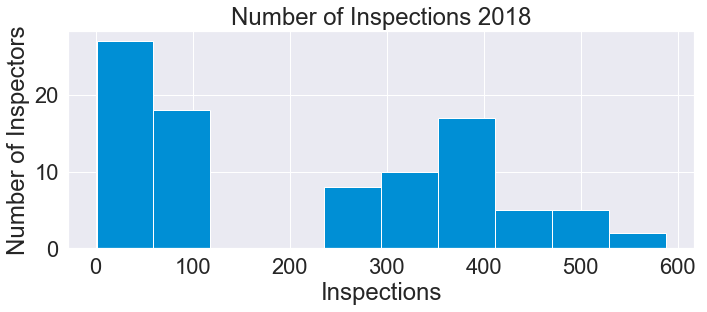

In [21]:
nv_2018 = nv.loc[nv['year_str']==2018, ['is_compliant', 'employee_id']]
counts = nv_2018.groupby(nv_2018['employee_id']).count().sort_values('is_compliant', ascending = False)
avg = nv_2018.groupby('employee_id').is_compliant.sum()

_=plt.rcParams["figure.figsize"] = [10,4]
_=counts.hist(edgecolor='w', lw=1)
_=plt.title('Number of Inspections 2018')
_=plt.xlabel('Inspections')
_=plt.ylabel('Number of Inspectors')

### Violations Count and Inspection Results
<p>Can the number of violations be an indicator of non-compliance and be more consistent with the grade received during an inspection than the type of violation? </p>
<p>The Southern Nevada Health District manages 90 different violation codes for restaurant inspections with each violation corresponding to a value that results in a grade. ‘A’ grades are given to establishments that are compliant (0 – 10 demerits), while ‘B’ (11 – 20) and ‘C’ (21-40) are downgrades and indicate critical or major violations.</p>

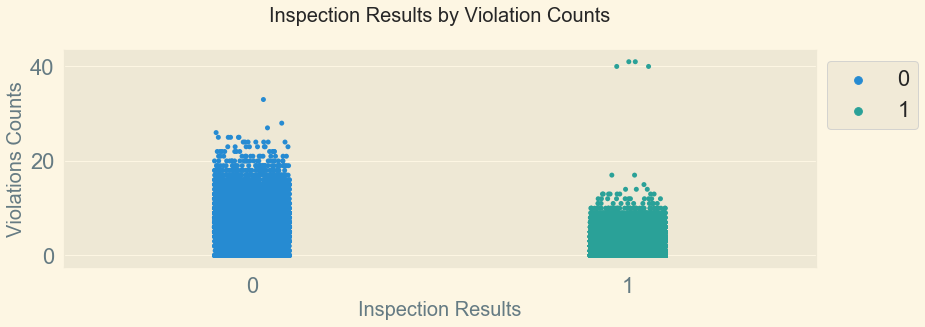

In [22]:
plt.rcParams['figure.figsize'] = [12,4]

plt.style.use('Solarize_Light2')
_=sns.stripplot("is_compliant", "violations_count", hue = "is_compliant", data = nv, jitter=True)
_=plt.legend(bbox_to_anchor=(1, 1), loc=2)
_=plt.xlabel('Inspection Results', fontsize = 20)
_=plt.ylabel('Violations Counts', fontsize = 20)
_=plt.title('Inspection Results by Violation Counts\n', fontsize = 20)

<p>An analysis of the violation counts by inspection shows that some restaurants with less than 17 violations can in fact received a non-compliance result. This shows that not all violations carry the same weight and even a restaurant with a single violation can be found non compliant, if the violation is an imminent public hazard. The same can be said  for a few restaurants that had multiple violations, but received passing grades.</p>

### Demerits and Grades

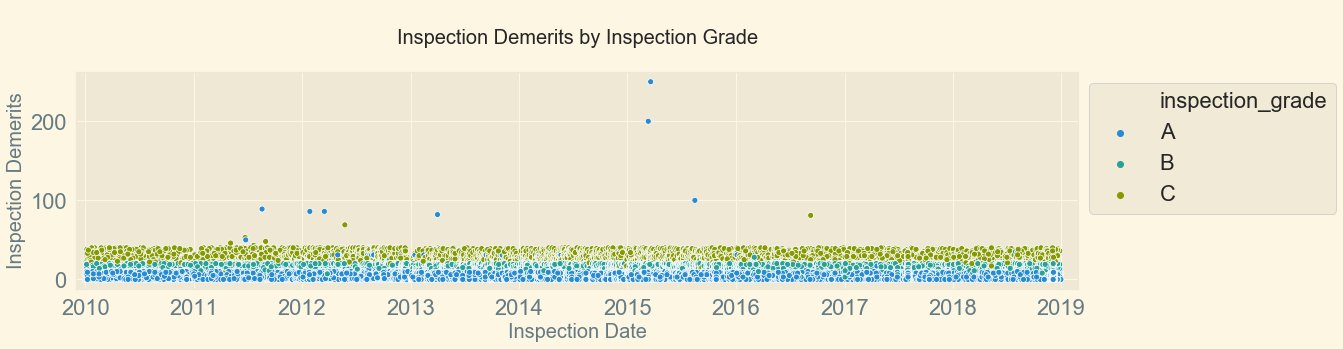

In [23]:
# subset the inspections set to get only non missing grades to plot
compliance = nv.dropna(how = 'any', subset = ['inspection_grade']).copy()
# subset main grades
rows = ['A', 'B', 'C']
compliance['inspection_demerits']=pd.to_numeric(compliance.inspection_demerits)
short = compliance.loc[compliance['inspection_grade'].isin(rows)]


# set plot parameters and plot using seaborn
plt.rcParams["figure.figsize"] = [16,4]
ax=sns.scatterplot(x='inspection_date', y='inspection_demerits', hue="inspection_grade", data=short)

# set the lengend outside the plot
_=plt.legend(bbox_to_anchor=(1, 1), loc=2)
_=ax.set(xlim = ('2009-12-01', '2019-2-28'))
_=plt.ylabel("Inspection Demerits", fontsize = 20)
_=plt.xlabel('Inspection Date', fontsize = 20)
_=plt.title('\nInspection Demerits by Inspection Grade\n', fontsize = 20)

<p>Since the number of violations alone doesn’t determine whether a food establishment passes or fails an inspection, an analysis of the points (demerits) obtained after each inspection shows that overall, establishments with fewer points receive a passing grade, even if they have more violation codes. This confirms that each violation have different weights, with critical violations being assigned higher values.</p>

### What's in a Grade and How They Have Changed Overtime

<p>Even though there are three main grades to indicate whether a restaurant is compliant,( A B, and C), the data shows that inspectors use at least 10 possible letter grades and 25 inspection result categories to record the inspection results. This wide range of grades and inspection results, can create inconsistencies to compare and analyze results, but in recording results, as inspectors could give different grades or result codes to similar violations.</p>

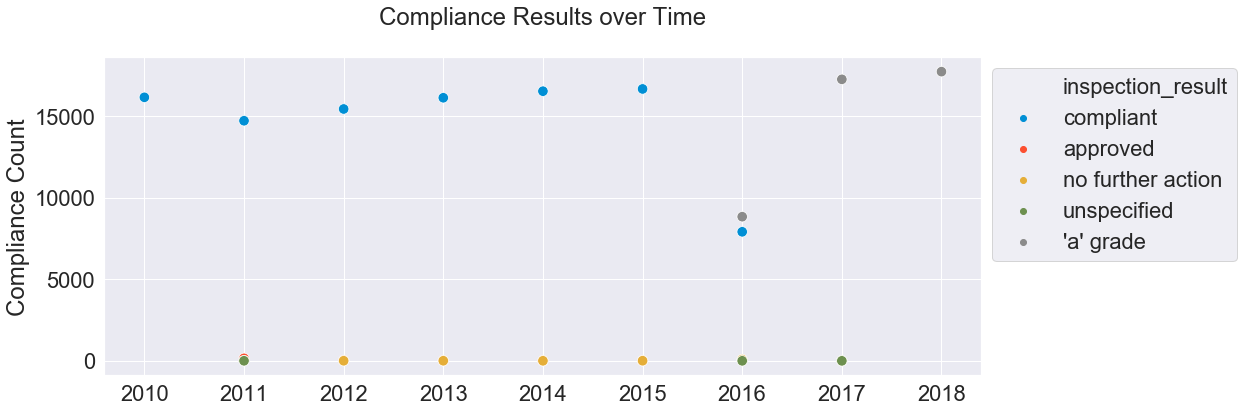

In [24]:
# show only passing inspection results
compliance = compliance.loc[compliance['is_compliant']==1]
# get group values by date and get the count of inspections by date
passing_grades = compliance.groupby([compliance["inspection_date"].dt.year, 'inspection_result','is_compliant']).size().reset_index()

# set figure size
_=plt.rcParams["figure.figsize"] = [14,12]
_=plt.style.use(['fivethirtyeight'])
sns.set_style(style = 'darkgrid')
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
_=plt.subplot(2,1,1)
# plot compliance frequency over time
_=sns.scatterplot(x='inspection_date', y = 0,hue="inspection_result", s = 110,data=passing_grades)
_=plt.title("Compliance Results over Time\n")
_=plt.xlabel('')
_=plt.ylabel('Compliance Count')
_=plt.legend(bbox_to_anchor=(1, 1), loc=2)

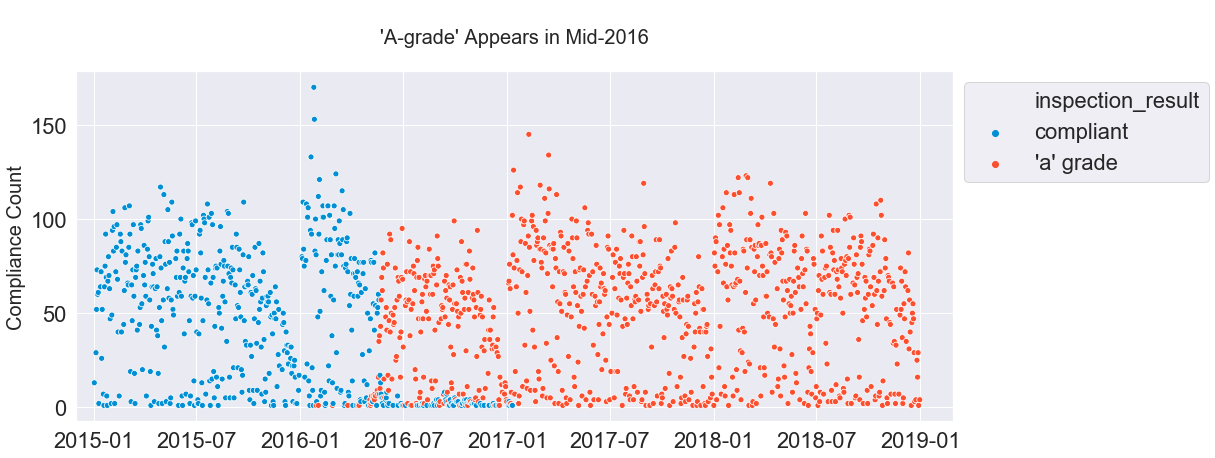

In [25]:
# subset the inspections set to get only non missing grades to plot
ir = ["'a' grade", "compliant", "'c' downgrade"]
compliance_2015 = compliance.loc[compliance['inspection_date']>='2015']
compliance_2015 = compliance_2015.loc[compliance_2015['inspection_result'].isin(ir)]
# get group values by date and get the count of inspections by date
grades = compliance_2015.groupby([compliance_2015["inspection_date"], 'inspection_result','is_compliant']).size().reset_index()

# set figure size
_=plt.rcParams["figure.figsize"] = [14,6]
# plot compliance frequency over time
ax=sns.scatterplot(x='inspection_date', y = 0,hue="inspection_result", data=grades)
_=plt.title("\n'A-grade' Appears in Mid-2016\n", fontsize = 20)
_=plt.xlabel('')
_=plt.ylabel('Compliance Count', fontsize = 20)
_=plt.legend(bbox_to_anchor=(1, 1), loc=2)
_=ax.set(xlim = ('2014-12-01', '2019-2-28'))

<p>The graphs above shows that up to 2016, most inspections with a passing grade would get a ‘compliant’ or ‘no further action’ inspection results to indicate compliance, and starting on 2016, inspection results have started to consolidate with inspectors using ‘compliant’, ‘A grade’ and ‘unspecified’ to record passing results.</p>

## Grades are Improving

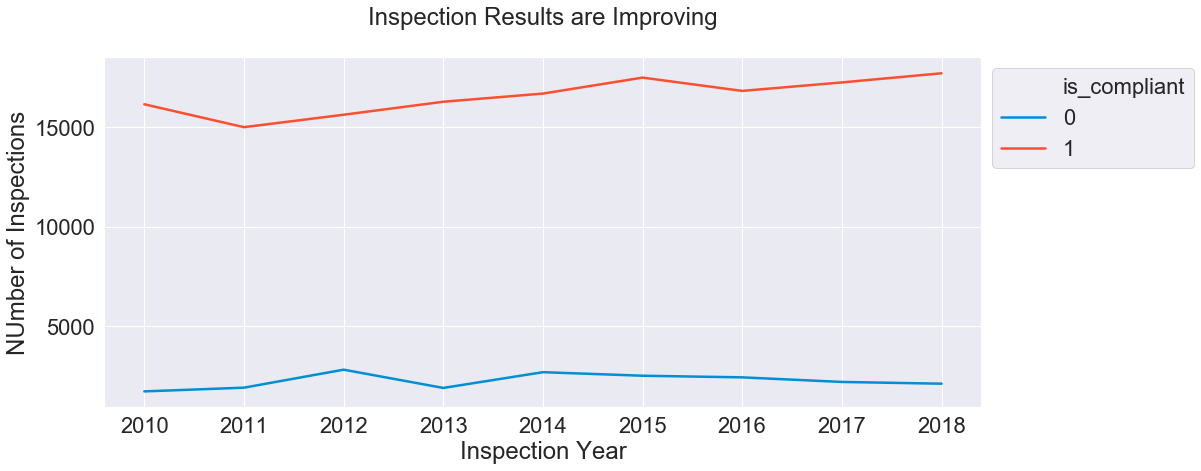

In [26]:
_=plt.rcParams['figure.figsize'] = [14,6]
grades = pd.DataFrame(nv.groupby(['is_compliant','year_str']).size()).sort_values(0, ascending=False).reset_index()

# plot A grades
_=sns.lineplot(x='year_str', y=0, hue="is_compliant", data=grades)
_=plt.legend(bbox_to_anchor=(1, 1), loc=2)
_=plt.xlabel('Inspection Year')
_=plt.ylabel('NUmber of Inspections')
_=plt.title('Inspection Results are Improving\n')

<p>In general, grades have improved over time. Since 2011 food establishments have constantly improved, with only a slight decline between 2015 and 2016 when grades were consolidated and inspectors started using A grades for compliance.</p>

## Inspection Results Frequency by Season Original Data

<p><b>Can seasonality impact inspection results?</b></p>
<p>One of the hypothesis for this project is that seasonal changes in weather may affect food handling and preparation, increasing the likelihood of food violations. The assumption is that higher temperatures during the summer months may increase the growth of bacteria if food is not prepared or consumed promptly. A detailed analysis of inspection results by season, showed that although there are less inspections during the summer months, the number of non-compliance results is slightly higher compared to other months, particularly when compared to winter inspection results. </p>

<p style="text-align:center">$H_0$: Compliance rate in cooler months = Compliance rate in warmer months </p>
    <p style="text-align:center">$H_A$: Compliance rate in warmer months $\neq$ compliance rate in cooler months </p>
    <p style="text-align:center">$\alpha$ = 0.05</p>

****

In [27]:
# Create a new column with the day of the year to get the season
nv['day_of_year'] = nv['inspection_date'].dt.dayofyear
# Define function to create season and investigate the frequency of inspection results
def season(df):
    """Return season name based on the northen hemisphere ranges during no leap years"""
    if df['day_of_year'] in range(79, 172):
        return 'spring'
    elif df['day_of_year'] in range(172, 266):
        return 'summer'
    elif df['day_of_year'] in range(266, 355):
        return'fall'
    else:
        return 'winter'

In [28]:
# run the function to create the season column
nv['season'] =  nv.apply (lambda df: season (df),axis=1)

<p>Based on all the inspection results, compliance in winter is slightly higher compared to other months with 88.7 %. Compliance during Spring months is 87.93 %, 87.89 % in the Fall and Summer has the lowest rate at 87.4%.</p>
<p>Since the Summer months tend to be specially busy with a growing number of tourists visiting the city, being able to predict and narrow the search of possible critical health violations, can minimize the risks of foodborne illness outbreaks.</p>

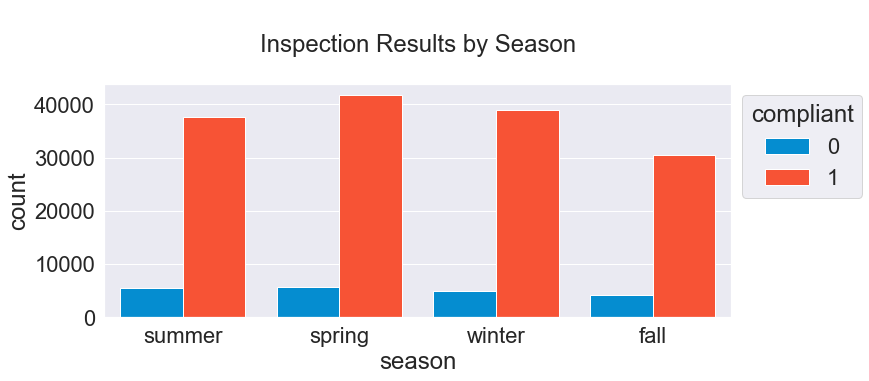

In [29]:
plt.rcParams['figure.figsize'] = [10,4]
_=sns.countplot(x="season", hue="is_compliant", data=nv, saturation=0.95, )
_=plt.legend(bbox_to_anchor=(1, 1), loc=2, title= 'compliant')
_=plt.title('\nInspection Results by Season\n')

#### Inspections over the years

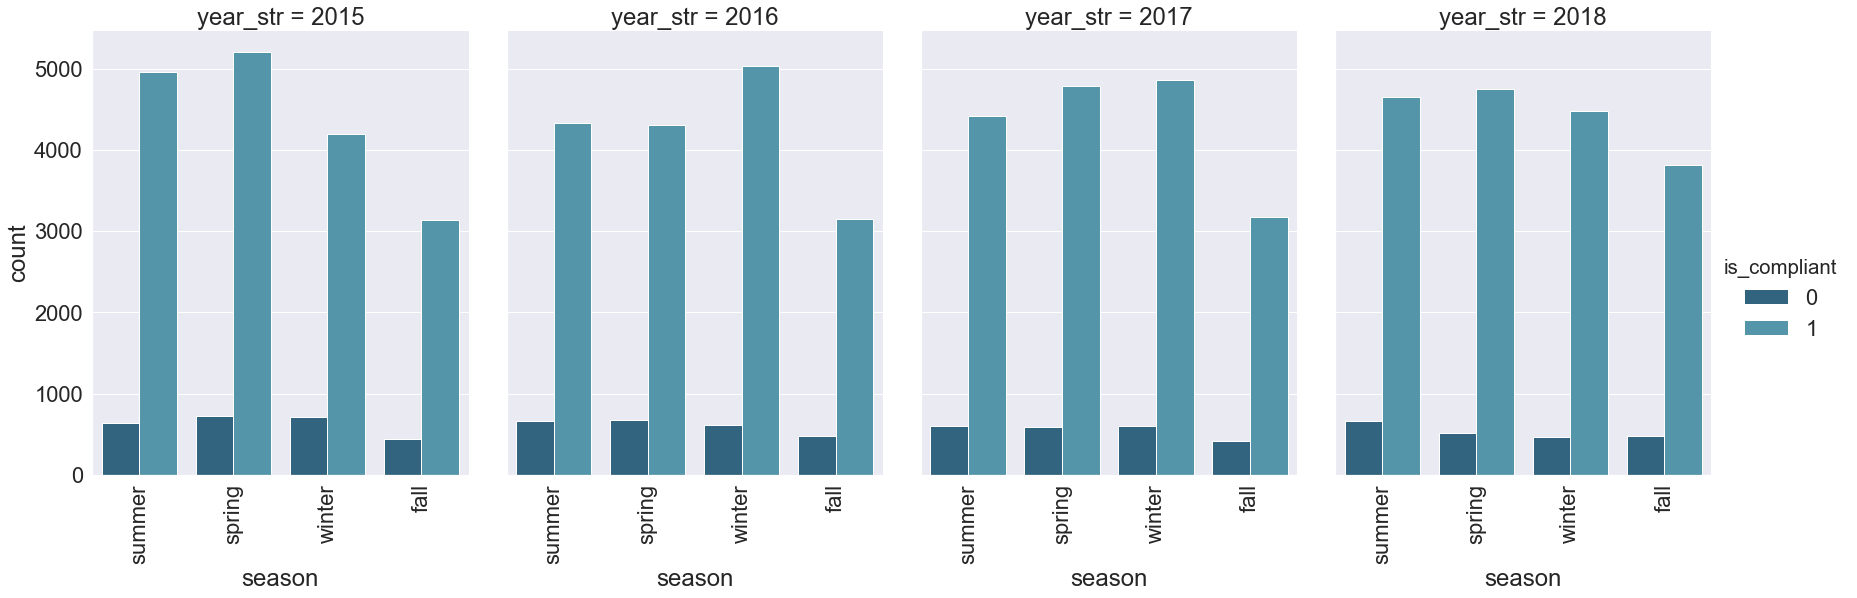

In [30]:
nv_2015 = nv[nv['inspection_date']<'2019']
_=sns.catplot(x="season", hue="is_compliant", col="year_str",
                capsize=.5, palette="YlGnBu_d", height=8, aspect=.75,
                kind="count", data=(nv_2015.loc[nv_2015['inspection_date']>'2015']))

_=_.set_xticklabels(rotation=90)

<p>A comparison over time shows that inspections consistently slow down during the fall and summer having the highest number of non-compliant results.</p>

### How significant is the impact of seasonality?
<p>In order to see the likelihood of getting these inspection results again, the data for winter and summer were randomly sampled, ignoring the season ‘labels’ to see if there is a statistically significant difference between the compliance results obtained during each season. Using a t-test, the results show that after 10000 simulations, the difference is statistically significant at the 0.05 level.</p>

In [31]:
# subset the data by season
spring = nv[nv['season']=='spring']
winter = nv[nv['season']=='winter']
summer = nv[nv['season']=='summer']
fall = nv[nv['season']=='fall']

seasons_list = ['Spring', 'Winter', 'Summer', 'Fall']

# convert data to array for easier analysis
compliance_spring = spring.is_compliant.values
compliance_winter = winter.is_compliant.values
compliance_summer = summer.is_compliant.values
compliance_fall = fall.is_compliant.values

# proportion of compliance by season
spring_prop = np.sum(compliance_spring)/len(compliance_spring)
winter_prop= np.sum(compliance_winter)/len(compliance_winter)
summer_prop= np.round((np.sum(compliance_summer)/len(compliance_summer)),4)
fall_prop= np.round((np.sum(compliance_fall)/len(compliance_fall)),4)

# combine lists into a dictionary of total number of inspections
seasons_props = [spring_prop, winter_prop, summer_prop, fall_prop]

freq = dict(zip(seasons_list,seasons_props))

for s,prop in freq.items():
    print('Proportion compliance %s: %.4f'%(s,prop))

Proportion compliance Spring: 0.8797
Proportion compliance Winter: 0.8866
Proportion compliance Summer: 0.8740
Proportion compliance Fall: 0.8788


In [32]:
def observed_diff(array1, array2):
    frac1 = np.sum(array1)/len(array1)
    frac2 = np.sum(array2)/len(array2)
    return frac1 - frac2

winter_summer = observed_diff(compliance_winter, compliance_summer)

# define permutation function
def permutation_samples(array1, array2):
    """Return a permutation sample from two arrays"""
    # concatenate the two arrays to 'remove' the labels and create the permuation sample
    both_df = np.concatenate((array1, array2))

    # mix the data
    both_perms = np.random.permutation(both_df)

    # randomly separate the data
    perm_1 = both_perms[:len(array1)]
    perm_2 = both_perms[len(array1):]
    
    return perm_1, perm_2

# define a function to compute n size permutation replicates
def permutation_replicates(array1, array2, function, size):
    """Return array of sample statistics computer from a permutation sample"""
    
    # create an empty array to store the replicates
    replicates_array = np.empty(10000)
    
    # create the permutation sample of size n
    for i in range(size):
        ps1, ps2 = permutation_samples(array1, array2)
    
        # compute the test statistic
        replicates_array[i] = function(ps1, ps2)
    
    return replicates_array

# critical value for 
critical_value = 1.96

In [33]:
# set the random seed
np.random.seed(88)

# combine arrays, ignore the labels and create a new set of arrays to compare if the results are the same
perm_sample1, perm_sample2 = permutation_samples(compliance_winter, compliance_summer)

# get the permutation replicates
perm_reps = permutation_replicates(compliance_winter, compliance_summer, observed_diff, 10000)

# calculate the probability
p_value = np.sum(perm_reps >=winter_summer)/len(perm_reps)

from scipy import stats
# t-statistc 
t_test =stats.ttest_ind(compliance_winter, compliance_summer)

t-statistic: 5.728242221760722
p-value: 0.0
Observed difference between winter and summer compliance: 0.013



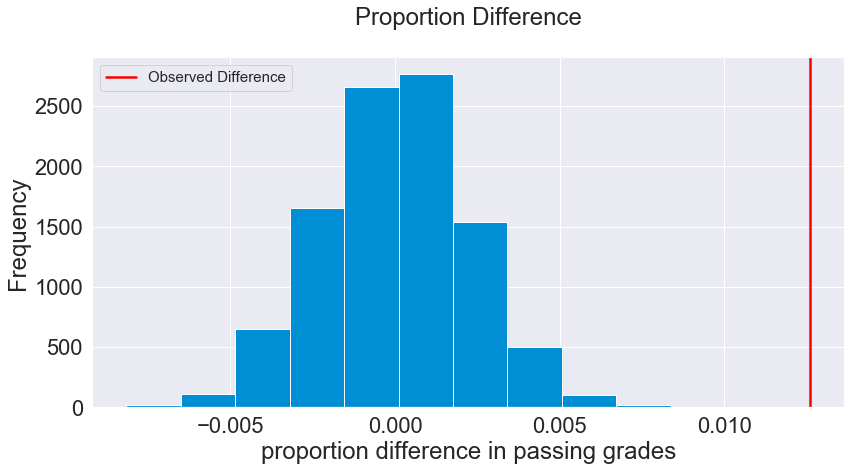

In [34]:
# visualize the results of the permutation replicates
_=plt.rcParams['figure.figsize'] = [12,6]
_=plt.title('Proportion Difference\n')
_=plt.axvline(winter_summer, color = 'red', label = 'Observed Difference')
_=plt.legend(['Observed Difference'], fontsize = 15)
_=plt.hist(perm_reps)
_=plt.xlabel('proportion difference in passing grades')
_=plt.ylabel('Frequency')

print('t-statistic:',t_test[0])
print('p-value:',p_value)
print('Observed difference between winter and summer compliance: %.3f'%(winter_summer), end='\n\n')

After simulating the inspection results 10,000 times, none of the simulations reached a difference at least as high as the observed difference of 1.3%. The result for the t-statistic, which was 5.72 (higher that the t critical value of 1.96) and the p-value was 0.0, suggests that the difference in passing grades between the two seasons is statistically significant at the 0.05 significance level.

## Where Inspection Priorities Lie

#### Who gets the most inspections?

<p>For inspection purposes, food establishments are classified into different categories based on the type of facility and food service they provide. This categorization can help distinguish not only how and when establishments can operate, but also how they prepare and handle food, which can be further used to analyze inspection results.</p>

<p>Based on the data, the Southern Nevada Health District uses 30 categories to distinguish food establishments. So, which ones get the most inspections?</p> <p><b>Restaurants as a general category account for the majority of inspections, followed by bars, snack bars, specialty kitchens, and elementary school kitchens</b>. Among the establishments with the least number of inspections are childcare kitchens, banquet support, beer bars, and Farmer’s markets.</p>

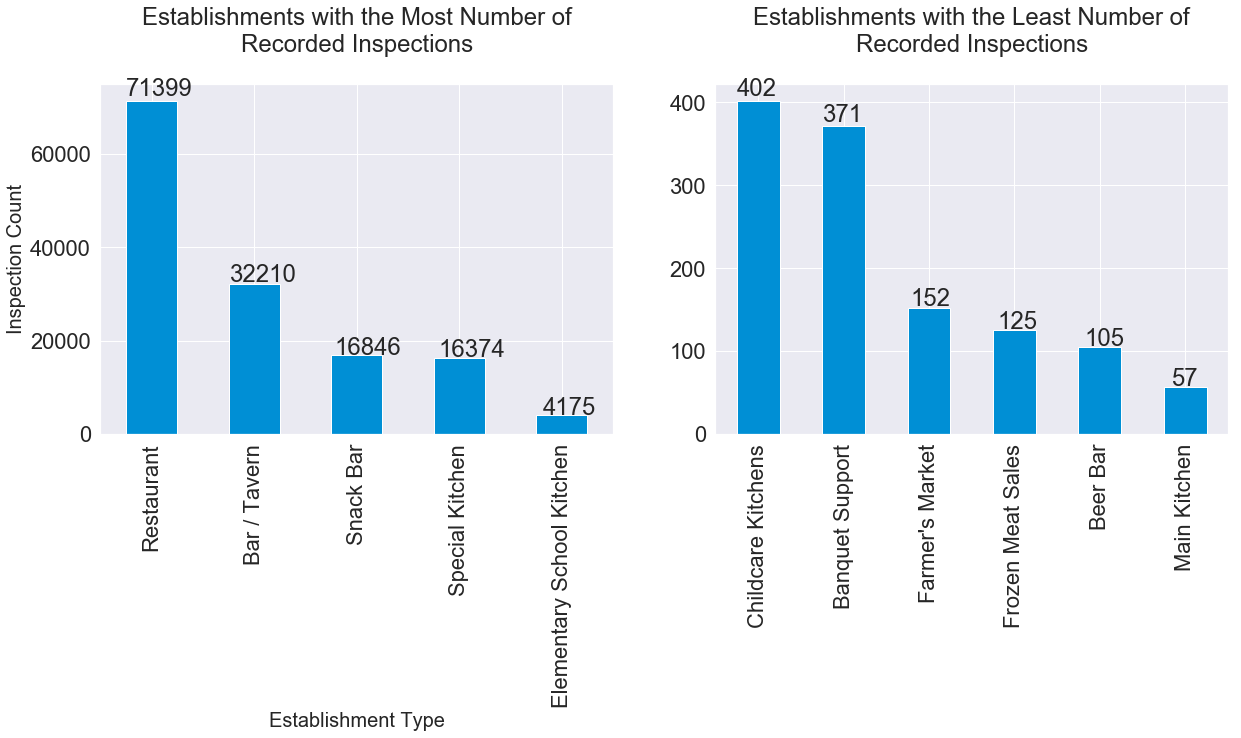

In [35]:
# set figure size, background and position of first plot
_=plt.rcParams['figure.figsize'] = [18,6]
_=plt.subplot(1,2,1)

# set font size and title
_=plt.title('Establishments with the Most Number of\nRecorded Inspections\n')

# plot first plot and add counts at the top of the bars
ax = nv.category_name.value_counts().head(5).plot(kind = 'bar', rot = 90)
for p in ax.patches:
    _=ax.annotate(str(p.get_height()), (p.get_x() * 1.018, p.get_height() * 1.015))
_=plt.xlabel('Establishment Type', fontsize= 20)
_=plt.ylabel('Inspection Count', fontsize = 20)
    
# set figure size and position of second plot   
_=plt.subplot(1,2,2)

# set title and plot bottom six and add the counts on top of the bars
_=plt.title('Establishments with the Least Number of\nRecorded Inspections\n')
ax = nv.category_name.value_counts().tail(6).plot(kind = 'bar', rot = 90)
for p in ax.patches:
    _=ax.annotate(str(p.get_height()), (p.get_x() * 1.018, p.get_height() * 1.015))

### How many are re-inspections?
However, not all inspections are equal. Establishments get routine inspections, but they also get can get a second inspection if they fail their first inspection. So, how many of the total inspections are re-inspections? As shown in the bar graph below, the large majority of inspections are routine inspections and only a small number of re-inspections. This shows the large majority of establishments are compliant.

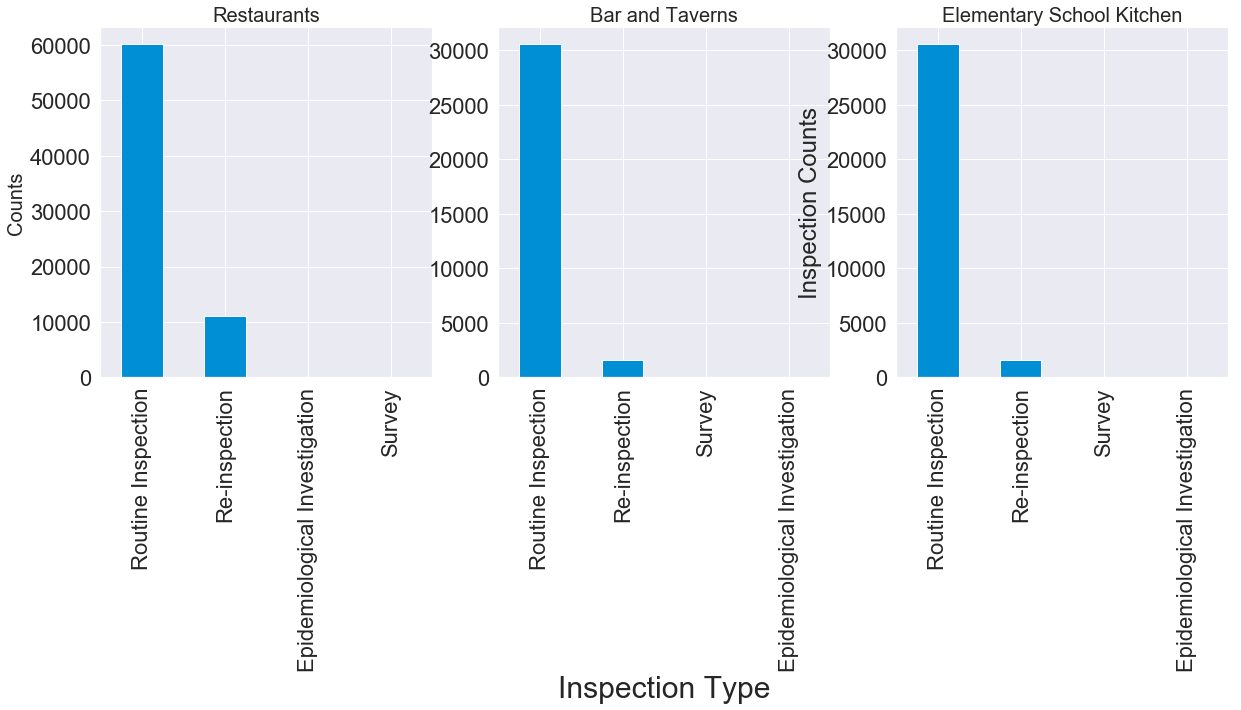

In [36]:
# subset top establisments to plot
r = nv.loc[nv['category_name']=='Restaurant']
b = nv.loc[nv['category_name']=='Bar / Tavern']
e = nv.loc[nv['category_name']=='Elementary School Kitchen']

# set figure size, main title and location of main title
_=plt.subplots(9)
_=plt.rcParams["figure.figsize"] = [18,6]
_=sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

# set the layout and position of plots
_=plt.subplot(1,3,1)

# plot inspection types for restaurants
_=r['inspection_type'].value_counts().plot(kind = 'bar', rot = 90)
_=plt.title('Restaurants', fontsize = 20)
_=plt.ylabel('Counts', fontsize = 20)

# plot inspection types for 'Bar / Tavern'
_=plt.subplot(1,3,2)
_=b['inspection_type'].value_counts().plot(kind = 'bar', rot = 90)
_=plt.title('Bar and Taverns', fontsize = 20)
_=plt.xlabel('Inspection Type', fontsize = 30)

# plot inspection types for 'Elementary School Kitchen'
_=plt.subplot(1,3,3)
_=plt.title('Elementary School Kitchen', fontsize = 20)
_=b['inspection_type'].value_counts().plot(kind = 'bar', rot = 90)
_=plt.ylabel('Inspection Counts')

<a id='yelpdata'></a>

****
# Collect Yelp Academic JSON Files
<p>In other to give more depth and perspective, Yelp data was added to the analysis. Although the Yelp data provides JSON files on business attributes, reviews, users, check-ins, tips and photos, only two files were used, the business data and reviews data.
Data files were retrieved directly from Yelp at https://www.yelp.com/dataset</p>

In [37]:
# function to read Yelp JSON files
def read_yelp(json_file_path):
    """read each JSON object as a json file and append it to the yelp data list"""
    try:
        yelp_data = []
        with open(json_file_path, 'r') as file:
            for line in file:
                json_file = json.loads(line)
                yelp_data.append(json_file)
        return yelp_data
    except:
        print('File not found')

## business.json
Data source: https://www.yelp.com/dataset

In [38]:
# read business json file
yelp_data = read_yelp(path+'yelp_academic_dataset_business.json')

In [39]:
print(type(yelp_data))
yelp_data[0]

<class 'list'>


{'business_id': 'Apn5Q_b6Nz61Tq4XzPdf9A',
 'name': 'Minhas Micro Brewery',
 'neighborhood': '',
 'address': '1314 44 Avenue NE',
 'city': 'Calgary',
 'state': 'AB',
 'postal_code': 'T2E 6L6',
 'latitude': 51.0918130155,
 'longitude': -114.031674872,
 'stars': 4.0,
 'review_count': 24,
 'is_open': 1,
 'attributes': {'BikeParking': 'False',
  'BusinessAcceptsCreditCards': 'True',
  'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",
  'GoodForKids': 'True',
  'HasTV': 'True',
  'NoiseLevel': 'average',
  'OutdoorSeating': 'False',
  'RestaurantsAttire': 'casual',
  'RestaurantsDelivery': 'False',
  'RestaurantsGoodForGroups': 'True',
  'RestaurantsPriceRange2': '2',
  'RestaurantsReservations': 'True',
  'RestaurantsTakeOut': 'True'},
 'categories': 'Tours, Breweries, Pizza, Restaurants, Food, Hotels & Travel',
 'hours': {'Monday': '8:30-17:0',
  'Tuesday': '11:0-21:0',
  'Wednesday': '11:0-21:0',
  'Thursday': '11:0-21:0',
  'Friday'

In [40]:
%time
# Normalize the JSON file to work with it in pandas
yelp_normalized = json_normalize(yelp_data)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


### Subset business data for State of Nevada
Since the Yelp data includes over 180,000 business in 10 metropolitan areas, the business data is filter to include only the establishments in Nevada.

In [41]:
# subset relevant columns
business = yelp_normalized.copy()[['business_id','address', 'attributes.Alcohol',
                                  'attributes.Caters','attributes.DogsAllowed',
                                  'attributes.Open24Hours','attributes.RestaurantsDelivery',
                                  'attributes.Smoking','categories', 'city','state',
                                  'latitude', 'longitude', 'name','postal_code','review_count', 'stars']]

In [42]:
# look at the data count by state
%time
from collections import Counter
_ = Counter(business.state)
print(_)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.3 µs
Counter({'AZ': 56495, 'NV': 35688, 'ON': 32393, 'NC': 14359, 'OH': 13664, 'PA': 10966, 'QC': 8756, 'AB': 7670, 'WI': 5042, 'IL': 1937, 'SC': 770, 'NYK': 163, 'NI': 134, 'IN': 101, 'OR': 72, 'BY': 60, 'ST': 45, 'CO': 43, 'C': 34, 'HE': 32, 'XGM': 23, 'NLK': 23, 'RP': 19, 'NY': 19, '01': 11, 'CA': 8, 'VS': 7, 'NW': 4, '6': 3, 'O': 3, 'CMA': 2, 'SG': 2, 'G': 2, 'B': 2, 'VT': 2, 'AL': 2, 'MO': 2, 'M': 2, 'AR': 2, 'WA': 2, 'VA': 1, 'RCC': 1, '4': 1, '10': 1, 'CC': 1, '45': 1, 'LU': 1, 'MT': 1, 'PO': 1, 'WAR': 1, 'HU': 1, 'FL': 1, 'KY': 1, 'CRF': 1, 'TAM': 1, 'NE': 1, 'XMS': 1, 'GA': 1, 'AG': 1, 'WHT': 1, 'MA': 1, 'V': 1, 'BC': 1, 'SP': 1, 'DE': 1, 'HH': 1, '11': 1, 'CS': 1, 'MN': 1})


In [43]:
# filter data only for Nevada
business = business.loc[business.state== 'NV']

***
## review.json
Data source: https://www.yelp.com/dataset

In [44]:
#path = file_path('pc')
review = read_yelp(path+'yelp_academic_dataset_review.json')

In [45]:
# preview the lenght of the file
len(review)

5996996

In [46]:
%time
# normalize reviews file
review_yelp = json_normalize(review)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


****
## Merge Yelp data

In [47]:
# confirm data loaded
print(review_yelp.shape)
print(business.shape)

(5996996, 9)
(35688, 17)


In [48]:
# keep only business_id, date and stars columns
review_yelp = review_yelp[['business_id','date','stars']]

In [49]:
# group review data by date and business id to get the daily stars rating average for each business 
#before merging it with the business data
r = review_yelp.groupby(['date','business_id',])['stars'].mean().reset_index()

In [50]:
#merge business and review data
yelp = pd.merge(left=business, right=r, on='business_id', how='inner')

****
## Data Wrangling Yelp

In [51]:
# remove spaces and change values to lower letter
yelp = col_cleanup(yelp, cols_list = ['name','address'])

# remove special characters
yelp['clean_name'] = rm_special_char(yelp['name'])

# split dates and create month and year columns
yelp = split_dates(yelp, col_date = 'date')

# convert postal code to string type for merge
yelp['postal_code'] = yelp['postal_code'].astype(str).str.split('.').str[0]

<a id='mergealldata'></a>

****
# Merge Inspections Results and Yelp Data

<p>Since there is no business ID match between the inspections results dataset and the Yelp data, the merge needs to be done using the establishment’s name, year of inspection, month of inspection and zip code. The year and the month will ensure that only current reviews and business data are included.
</p>

In [52]:
# make copy of the inspections result data
inspections = nv.copy()

In [53]:
# merge inspections and yelp data using name, year, month and zipcode
results = pd.merge(inspections, yelp, left_on=['clean_name', 'year_str', 'month_str','zip_code'],
                   right_on=['clean_name', 'year_str','month_str', 'postal_code'])

In [54]:
# review the size of the final dataset
#results.columns
results.shape

(35242, 47)

In [55]:
# change inspection results to lower case and remove white spaces using user defined function
results = col_cleanup(results, cols_list = ['inspection_result'])

In [56]:
# rename column names
results = results.rename(columns = {'city_x': 'city','location_1.coordinates':'coordinates','attributes.Alcohol':'serve_alcohol',
                         'attributes.Caters':'caters','attributes.RestaurantsDelivery':'delivery',
                         'stars_x':'stars_business','stars_y':'stars_review','date':'review_date','day_str_x':'weekday'})

In [57]:
# convert inspection data and review date to data types for ease of analysis
results['inspection_date'] = pd.to_datetime(results['inspection_date'])
results['review_date'] = pd.to_datetime(results['review_date'])

<a id='EDAcompletedata'></a>

***
# EDA and Feature Engineering Complete Dataset

Since the data are very sparse across business attributes, similar categories are grouped, rename, and changed into binary features for the predictive model.
Star ratings are given different weights based on the inspection date and review date to make star ratings closer to the inspection date have more weight even when two different reviews have the same rating, but happened on different dates. 

In [58]:
# create a new column with difference between review date and inspection date
def diff_dates(d1, d2):
    return(d2 - d1)

In [59]:
# apply user defined function
results['diff_dates'] = diff_dates(results['inspection_date'], results['review_date']).dt.days

In [60]:
# round the stars review to 1 decimal
results['stars_review'] = results['stars_review'].astype(float)
results['stars_review'] = results.stars_review.round(1)


<p>Once the inspections and Yelp datasets were merged, the first step was to review the distribution of the target variable to see if it was unbalanced. The plot showed that the proportion of passing grades is 76%, which is a fairly balanced distribution.</p>

Proportion of compliance: 0.7603



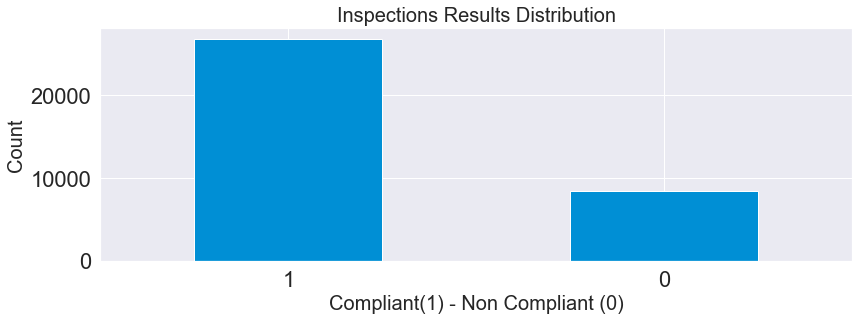

In [61]:
_=plt.rcParams["figure.figsize"] = [12,4]
_=results['is_compliant'].value_counts().plot(kind = 'bar', rot = 0)
_=plt.title('Inspections Results Distribution', fontsize = 20)
_=plt.ylabel('Count', fontsize = 20)
_=plt.xlabel('Compliant(1) - Non Compliant (0)', fontsize = 20)

yes = np.sum(results['is_compliant'])

print('Proportion of compliance:', np.round((yes/len(results)),4),end='\n\n')

### Star Ratings and Inspection Results
<p>One of the assumptions prior to the analysis was that the average daily star ratings were positively correlated with inspection results. Hence, five star ratings would be highly correlated with passing grades. The analysis showed that the typical star ratings of most of the establishments with passing grades were 4 and 5 stars with a few establishments with 5 star rating and non-compliance results.</p>

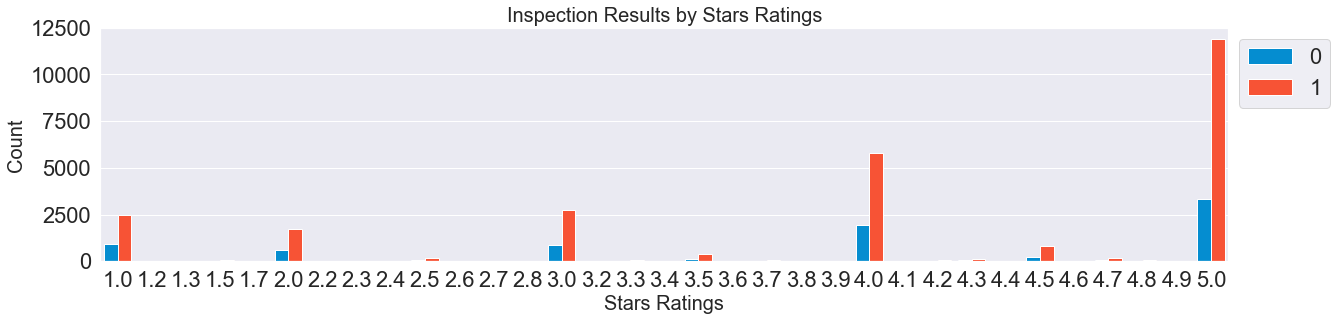

In [62]:
plt.rcParams["figure.figsize"] = [18,4]
_=sns.countplot(x="stars_review", hue="is_compliant", data=results, saturation=0.95)
_=plt.legend(bbox_to_anchor=(1, 1), loc=2)
_=plt.xlabel('Stars Ratings', size = 20)
_=plt.ylabel('Count', fontsize = 20)
_=plt.title('Inspection Results by Stars Ratings', fontsize = 20)

In [63]:
# add more weight to star ratings closer to the inspection date
# make the weight to be inversely proportional to the variance of ratings
ratings_weight = 1/np.var(results['stars_review'])

# multiply the weight by the difference in dates between inspection and rating only if ratings are before inspection date
results['weight_diff_date'] = [(-1/(x*ratings_weight)) if x < 0 else x * 0 for x in results['diff_dates'] ] # maybe try to use the actual rating insted of using 0

#try with all the ratings
results['weight_diff_date_with_all'] = [(-1/(x*ratings_weight)) if x < 0 else x*(-ratings_weight) for x in results['diff_dates'] ]


In [64]:
# multiply the actual rating by the weigthed time rating
results['weighted_rating'] =(np.round((results['stars_review'] * results['weight_diff_date']),1))

# try with all the ratings
results['weighted_rating_with_all'] =(np.round((results['stars_review'] * results['weight_diff_date_with_all']),1))

****

## Combine Similar Food Categories
<p>Since all the business attributes are recorded in a single variable, in order to better fit the model, the attributes were split into binary features by first combining similar categories to reduce the number of possible features and avoid data points from being too sparse.</p>

In [65]:
# remove similar variables
remove = ['address_x','city','employee_id', 'inspection_date','inspection_grade', 'inspection_result','inspection_time','location_name',
         'restaurant_name', 'violations','zip','coordinates', 'clean_name','business_id', 'address_y','serve_alcohol', 'attributes.Open24Hours','caters',
          'attributes.DogsAllowed','attributes.Smoking', 'city_y', 'state','name','day_str_y', 'delivery','postal_code']

results_short = results.drop(remove, axis = 1)

In [66]:
# split categories into two columns to extract the cuisine and establishment type
results_short['type'] = [x.split(",")[0] for x in results_short['categories']]
results_short['type_2'] = [x.split(", ")[1] for x in results_short['categories']]

In [67]:
# create list of possible categories
some_values=['Buffets', 'Buffet','Grocery','Specialty Food','Food Delivery Services','Restaurant','Restaurants']
snack_bar = ['Fitness & Instruction','Candy Stores','Popcorn Shops','Convenience Stores','Car Dealers','Auto Repair','Playgrounds',
             'Lounges','Pilates','Beauty & Spas','Massage','Gun/Rifle Ranges','Gift Shops','Hair Salons','Flowers & Gifts',
             'Makeup Artists','Shopping','Florists','Arts & Crafts','Wholesale Stores']             
bakeries = ['Patisserie/Cake Shop','Cupcakes','Bakeries','Bakery Sales','Bagels','Pretzels','Custom Cakes','Bakeries','Kitchen Bakery']
desserts = ['Creperies','Waffles','Gelato','Chocolatiers & Shops','Shaved Ice','Shaved Snow','Ice Cream & Frozen Yogurt']
#icecream = ['Shaved Ice','Shaved Snow']
asian = ['Pakistani', 'Afghan','Filipino','Mongolian','Korean','Vietnamese','Taiwanese']
venues = ['Cinema','Arts & Entertainment','Ticket Sales','Performing Arts','Venues & Event Spaces',
          'Wedding Chapels','Local Flavor','Party & Event Planning','Caterers','Caterer','Event Planning & Services']
latin = ['Peruvian','Caribbean','Salvadoran','Venezuelan','Cuban','Puerto Rican','Argentine']
middleEastern = ['Kebab', 'Arabian', 'Lebanese','Persian/Iranian','Halal']
foodtruck = ['Food Trucks','Street Vendors','Food Stands','Falafel','Portable Unit']
mediterranean = ['Greek','Moroccan']
fastfood = ['Hot Dogs','Burgers','Chicken Wings','Cheesesteaks','Poutineries']
mexican = ['New Mexican Cuisine','Tacos','Tex-Mex']
#sushi = ['Conveyor Belt Sushi']
japanese = ['Ramen','Teppanyaki','Noodles','Conveyor Belt Sushi','Sushi Bars']
bars = ['Cocktail Bars','Wine Bars','Gastropubs','Sports Bars','Dive Bars','Beer Bar','Beer','Breweries','Hookah Bars',
        'Pubs','Beer Gardens','Bars','Karaoke','Adult Entertainment','Paint & Sip','Nightlife','Strip Clubs','Casinos',
        'Hotels & Travel','Arcades']
american = ['Southern','Comfort Food','Cajun/Creole','Soul Food','Barbeque','Tobacco Shops']
ethnic = ['Ethiopian']
snacks = ['Wraps','Salad','Soup']
teashop = ['Tea Rooms','Bubble Tea']
vegan = ['Vegetarian']
spanish =['Tapas/Small Plates','Tapas Bars']
hawaiian = ['Poke']
chinese = ['Dim Sum','Szechuan','Cantonese','Hot Pot']
cafe = ['Coffee Roasteries','Coffeeshops','Coffee & Tea','Cafeteria']
italian = ['Pasta Shops', 'Pizza']
meats = ['Seafood','Chicken Shop','Live/Raw Food']
juices = ['Acai Bowls']
health = ['Fruits & Veggies','Farmers Market','Water Stores','Water Purification Services']
european = ['Fondue', 'French', 'German','Modern European','Russian']

# create function to combine categories
def change_type(df):
    """Check the value in the type column and return a new category name"""
    if df.type in some_values:
        return df.category_name
    elif df.type in snack_bar:
        return 'Snack Bar'
    elif df.type in bakeries:
        return 'Kitchen Bakery'
    elif df.type in desserts:
        return 'Desserts'
    #elif df.type in icecream:
        #return 'Ice Cream & Frozen Yogurt'
    elif df.type in asian:
        return 'Asian Fusion'
    elif df.type in venues:
        return 'Venues & Event Spaces'
    elif df.type in latin:
        return 'Latin American'
    elif df.type in middleEastern:
        return 'Middle Eastern'
    elif df.type in foodtruck:
        return 'Food Trucks / Mobile Vendor'
    elif df.type in mediterranean:
        return 'Mediterranean'
    elif df.type in fastfood:
        return 'Fast Food'
    elif df.type in mexican:
        return 'Mexican'
    #elif df.type in sushi:
        #return 'Sushi Bars'
    elif df.type in japanese:
        return 'Japanese'
    elif df.type in bars:
        return 'Bar / Tavern'
    elif df.type in american:
        return 'American (Traditional)'
    elif df.type in ethnic:
        return 'Ethnic Food'
    elif df.type in snacks:
        return 'Sandwiches'
    elif df.type in teashop:
        return 'Taiwanese'
    elif df.type in vegan:
        return 'Vegan'
    elif df.type in spanish:
        return 'Spanish'
    elif df.type in hawaiian:
        return 'Hawaiian'
    elif df.type in chinese:
        return 'Chinese'
    elif df.type in cafe:
        return 'Cafes'
    elif df.type in italian:
        return 'Italian'
    elif df.type in meats:
        return 'Meat/Poultry/Seafood'
    elif df.type in juices:
        return 'Juice Bars & Smoothies'
    elif df.type in health:
        return 'Health Markets'
    elif df.type in european:
        return 'Modern European'
    else:
        return df.type


In [68]:
# define function of type_2 column
def change_type2(df):
    if df.type_2 in some_values:
        return df.category_name
    elif df.type_2 in snack_bar:
        return 'Snack Bar'
    elif df.type_2 in bakeries:
        return 'Kitchen Bakery'
    elif df.type_2 in desserts:
        return 'Desserts'
    #elif df.type_2 in icecream:
        #return 'Ice Cream & Frozen Yogurt'
    elif df.type_2 in asian:
        return 'Asian Fusion'
    elif df.type_2 in venues:
        return 'Venues & Event Spaces'
    elif df.type_2 in latin:
        return 'Latin American'
    elif df.type_2 in middleEastern:
        return 'Middle Eastern'
    elif df.type_2 in foodtruck:
        return 'Food Trucks / Mobile Vendor'
    elif df.type_2 in mediterranean:
        return 'Mediterranean'
    elif df.type_2 in fastfood:
        return 'Fast Food'
    elif df.type_2 in mexican:
        return 'Mexican'
    #elif df.type_2 in sushi:
        #return 'Sushi Bars'
    elif df.type_2 in japanese:
        return 'Japanese'
    elif df.type_2 in bars:
        return 'Bar / Tavern'
    elif df.type_2 in american:
        return 'American (Traditional)'
    elif df.type_2 in ethnic:
        return 'Ethnic Food'
    elif df.type_2 in snacks:
        return 'Sandwiches'
    elif df.type_2 in teashop:
        return 'Taiwanese'
    elif df.type_2 in vegan:
        return 'Vegan'
    elif df.type_2 in spanish:
        return 'Spanish'
    elif df.type_2 in hawaiian:
        return 'Hawaiian'
    elif df.type_2 in chinese:
        return 'Chinese'
    elif df.type_2 in cafe:
        return 'Cafes'
    elif df.type_2 in italian:
        return 'Italian'
    elif df.type_2 in meats:
        return 'Meat/Poultry/Seafood'
    elif df.type_2 in juices:
        return 'Juice Bars & Smoothies'
    elif df.type_2 in health:
        return 'Health Markets'
    elif df.type_2 in european:
        return 'Modern European'
    else:
        return df.type_2

In [69]:
# Apply function to first category type
results_short['type'] = results_short.apply (lambda df: change_type (df),axis=1)

In [70]:
# apply function to second category type
results_short['type_2'] = results_short.apply (lambda df: change_type2 (df),axis=1)

In [71]:
# create a new feature with the grouped food type
def f_type(df):
    """Return category name based on the value of the values in type or type_2 columns"""
    if df['type'] == 'Restaurant':
        return df['type_2']
    elif df['type']== 'Food':
        return df['type_2']
    else:
        return df['type']

In [72]:
# apply food type function to create new feature with cuisine types
results_short['food_type'] = results_short.apply (lambda df: f_type (df),axis=1)

In [73]:
# do one additional clean up of the food type feature
condlist = [results_short['food_type']=='Florists',results_short['food_type']=='Specialty Schools',results_short['food_type']=='Concessions', 
            results_short['food_type']=='Confection',results_short['food_type']=='Portable Unit',results_short['food_type']=='Chicken Shop']

choices = ['Specialty Food','Special Kitchen','Snack Bar','Snack Bar','Food Trucks / Mobile Vendor','Meat/Poultry/Seafood']

results_short['food_type'] = np.select(condlist=condlist, choicelist=choices, default=results_short['food_type'])


### Compliance by Food Type
<p>Another general assumption was that the establishment type and the food type may impact inspection results. For instance, establishments with buffet options and/or raw food menus may have higher food violations due to stricter standards of temperature and food handling.</p>
<p>The hypotheses were:</p>
<p style="text-align:center">$H_0$: There is no significant difference in compliance rates by food type.</p>
<p style="text-align:center">$H_A$: compliance rate among establishments varies between food type.</p>
<p style="text-align:center">$\alpha$ = 0.05</p>

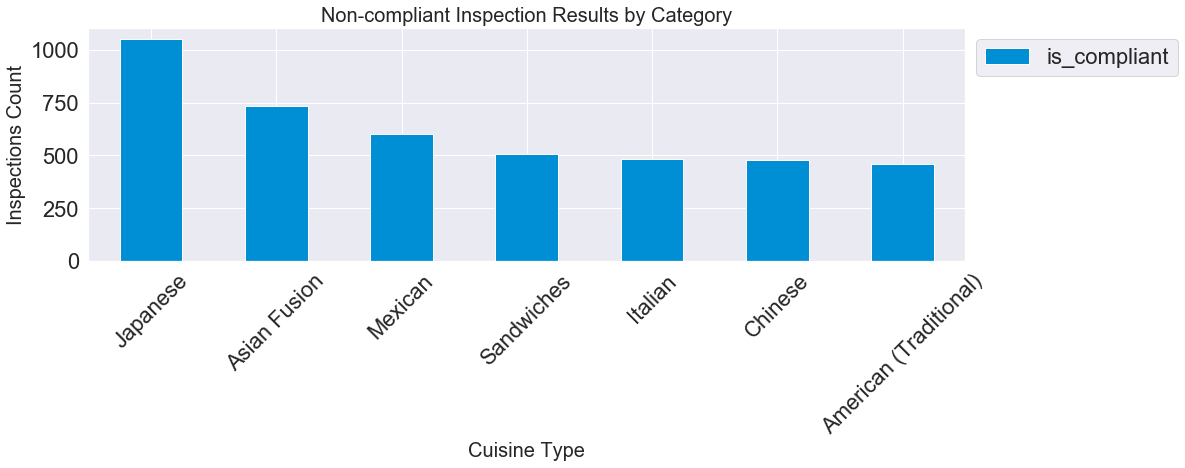

In [74]:
# subset the data to show food types != 'Restaurants' or 'Food'
cats = results_short[(results_short.food_type != 'Restaurants') | (results_short.food_type != 'food_type')]
non_compliant = cats.loc[cats['is_compliant']==0, ['is_compliant','food_type']]
_=plt.rcParams["figure.figsize"] = [14,4]

# plot top 7 food type categories with the largest number of non-compliant results
_=non_compliant.groupby(['food_type']).count().sort_values(['is_compliant'], ascending = False).head(7).plot(kind = 'bar', rot = 45)
_=plt.xlabel("Cuisine Type", fontsize = 20)
_=plt.legend(bbox_to_anchor=(1, 1), loc=2)
_=plt.title('Non-compliant Inspection Results by Category', fontsize = 20)
_=plt.xlabel('Cuisine Type', fontsize = 20)
_=plt.ylabel('Inspections Count', fontsize = 20)

<p>Looking at the distribution of compliance rates across different establishment types, Yelp data showed that establishments categorized as ‘Japanese’ had a higher number of ‘non compliant’ results followed by Asian Fusion, Mexican, Sandwiches, and Italian.</p>

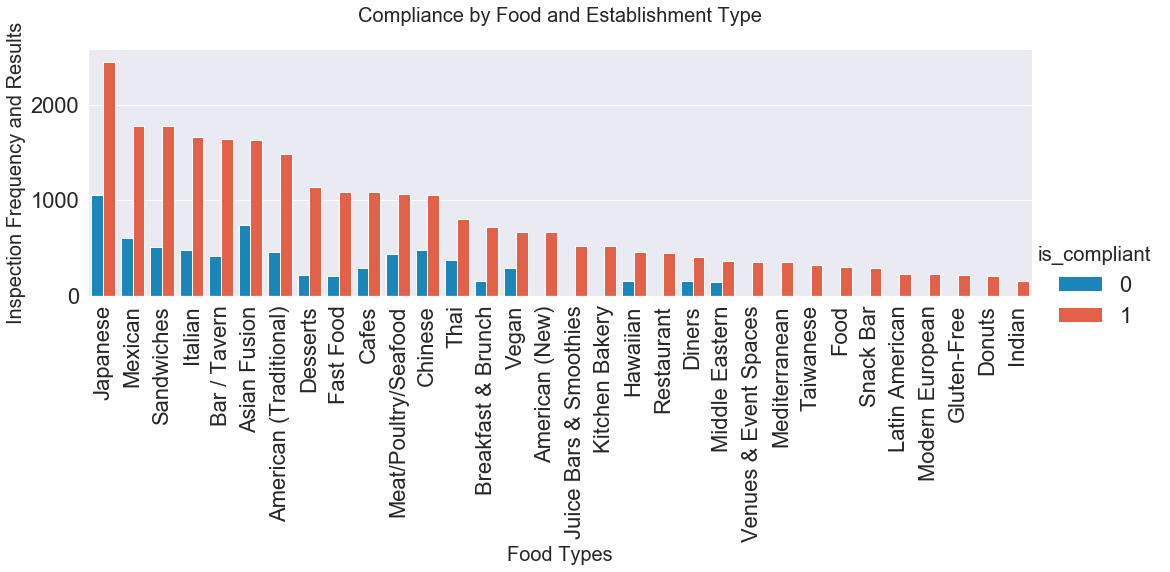

In [75]:
# show the top 50 food type and establishment type inspection results
_=plt.rcParams["figure.figsize"] = [14,6]

# get a count of inspection results
l=cats.groupby(['is_compliant','food_type']).size().reset_index()

# sort results to show only the top 50
l_sorted=l.sort_values(0, ascending = False).head(50)

# plot the results
_= sns.catplot(x="food_type", y=0, hue="is_compliant", data=l_sorted, kind="bar",height=5, aspect=3)
_=plt.xticks(rotation=90)
_=plt.xlabel('Food Types', fontsize = 20)
_=plt.ylabel('Inspection Frequency and Results', fontsize = 20)
_=plt.title('Compliance by Food and Establishment Type\n', fontsize = 20)

In [76]:
#create a copy to get correlation of main variables
results_short_no_dummies = results_short.copy()

### Inspection Results Frequency by Season
<p>Does the difference in inspection results by season still hold with the smaller dataset?</p>
<p>The same analysis was done on the final dataset to confirm the differences observed in the inspections data were carried to this final dataset. .</p>

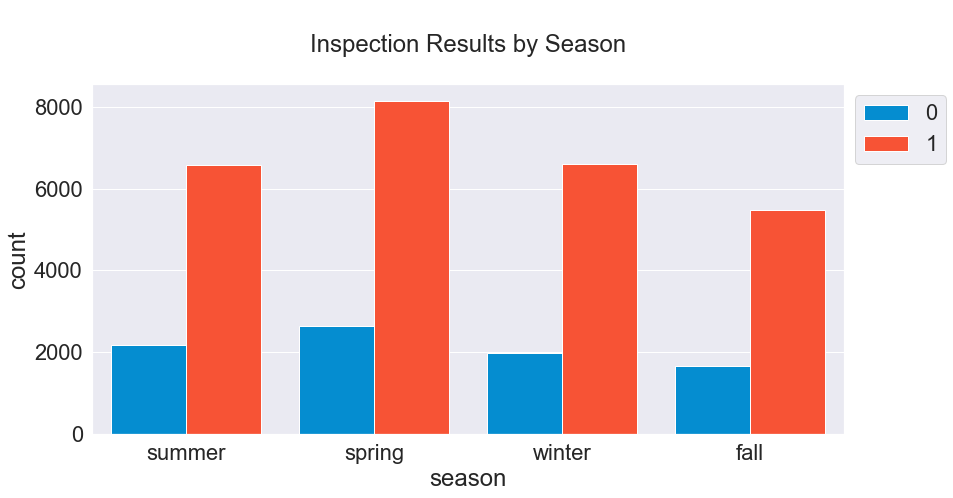

In [77]:
# set graph parameters
plt.rcParams['figure.figsize'] = [12,6]
# look at the distribution of inspection results
_=sns.countplot(x="season", hue="is_compliant", data=results_short, saturation=0.95, )
_=plt.legend(bbox_to_anchor=(1, 1), loc=2)
_=plt.title('\nInspection Results by Season\n')

In [78]:
# subset data by season to find if the difference in results is significant
spring_df = results_short[results_short['season']=='spring']
winter_df = results_short[results_short['season']=='winter']
summer_df = results_short[results_short['season']=='summer']
fall_df = results_short[results_short['season']=='fall']

In [79]:
# combine lists into a dictionary of total number of inspections
seasons_counts = [spring_df, winter_df, summer_df, fall_df]
seasons_list = ['Spring', 'Winter', 'Summer', 'Fall']

freq = dict(zip(seasons_list,seasons_counts))

# print number of inspections
for d,f in freq.items():
    print('Compliance results %s: %.4d'%(d,np.sum(f.is_compliant)))

Compliance results Spring: 8136
Compliance results Winter: 6591
Compliance results Summer: 6580
Compliance results Fall: 5486


In [80]:
# convert data to array for easier analysis
compliance_spring = spring_df.is_compliant.values
compliance_winter = winter_df.is_compliant.values
compliance_summer = summer_df.is_compliant.values
compliance_fall = fall_df.is_compliant.values

# proportion of compliance by season
spring_prop = np.sum(compliance_spring)/len(compliance_spring)
winter_prop= np.sum(compliance_winter)/len(compliance_winter)
summer_prop= np.round((np.sum(compliance_summer)/len(compliance_summer)),3)
fall_prop= np.round((np.sum(compliance_fall)/len(compliance_fall)),3)

seasons_props = [spring_prop, winter_prop, summer_prop, fall_prop]

freq_df = (dict(zip(seasons_list, seasons_props)))

# print number of inspections
for d,f in freq_df.items():
    print('Compliance results %s: %.2f'%(d,f))

Compliance results Spring: 0.76
Compliance results Winter: 0.77
Compliance results Summer: 0.75
Compliance results Fall: 0.77


In [81]:
def observed_diff(array1, array2):
    frac1 = np.sum(array1)/len(array1)
    frac2 = np.sum(array2)/len(array2)
    return frac1 - frac2

winter_summer = observed_diff(compliance_winter, compliance_summer)
print(('\nobserved difference in compliance rate between Winter and Summer: %.3f')%(winter_summer))


observed difference in compliance rate between Winter and Summer: 0.017


The results were very similar. The difference in compliance results between winter and summer were 0.017, in line with the 0.013 obtained with the inspections data alone.

### Probability of Seeing Difference Results

In [82]:
# define permutation function
def permutation_samples(array1, array2):
    """Return a permutation sample from two arrays"""
    # concatenate the two arrays to 'remove' the labels and create the permuation sample
    both_df = np.concatenate((array1, array2))

    # mix the data
    both_perms = np.random.permutation(both_df)

    # randomly separate the data
    perm_1 = both_perms[:len(array1)]
    perm_2 = both_perms[len(array1):]
    
    return perm_1, perm_2

# define a function to compute n size permutation replicates
def permutation_replicates(array1, array2, function, size):
    """Return array of sample statistics computer from a permutation sample"""
    
    # create an empty array to store the replicates
    replicates_array = np.empty(10000)
    
    # create the permutation sample of size n
    for i in range(size):
        ps1, ps2 = permutation_samples(array1, array2)
    
        # compute the test statistic
        replicates_array[i] = function(ps1, ps2)
    
    return replicates_array

# critical value for 
critical_value = 1.96

In [83]:
# set the random seed
np.random.seed(88)

# combine arrays, ignore the labels and create a new set of arrays to compare if the results are the same
perm_sample1, perm_sample2 = permutation_samples(compliance_winter, compliance_summer)

# get the permutation replicates
perm_reps = permutation_replicates(compliance_winter, compliance_summer, observed_diff, 10000)

# calculate the probability
p_value = np.sum(perm_reps >=winter_summer)/len(perm_reps)

from scipy import stats
# t-statistc 
t_test =stats.ttest_ind(compliance_winter, compliance_summer)

print('p-value:',p_value)
print('t-statistic:',t_test[0])

p-value: 0.004
t-statistic: 2.6309507126404825


Once again, after simulating the inspection results 10,000 times, none of the simulations reached a difference at least as high as the observed difference of 1.6%. The result for the t-statistic, which was 2.63 (higher that the t critical value of 1.96) and the p-value was 0.0005, suggests that the difference in passing grades between the two seasons is statistically significant at the 0.05 significance level.

### Does the day of the week have an impact on inspection results? 
<p>A similar comparison was done with the days of the week. However, the data shows that compliance is not significantly different between days.</p>

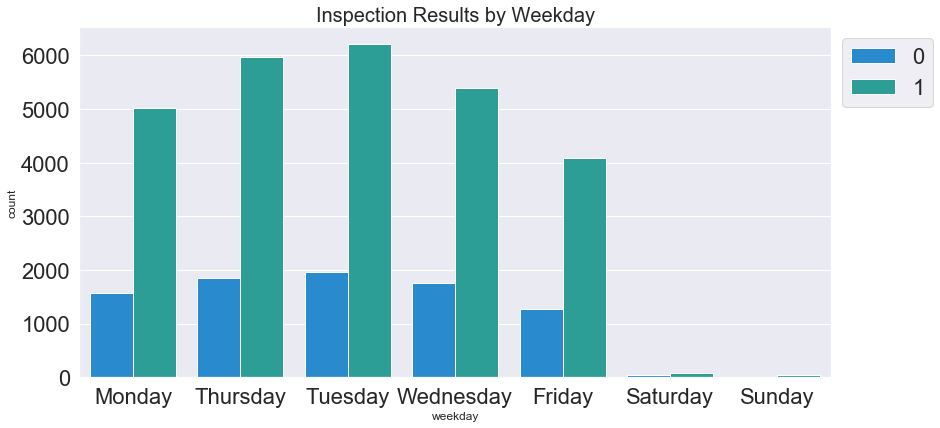

In [84]:
plt.rcParams['figure.figsize'] = [12,6]
_=plt.style.use('Solarize_Light2')
_=sns.set_style(style = 'darkgrid')
_=sns.countplot(x="weekday", hue="is_compliant", data=results_short, saturation=0.95)
_=plt.legend(bbox_to_anchor=(1, 1), loc=2)
_=plt.title('Inspection Results by Weekday', fontsize = 20)

In [85]:
# subset data by weekday to find if the observed difference are satistically significant
mon = results_short[results_short['weekday']=='Monday']
tues = results_short[results_short['weekday']== 'Tuesday']
wed = results_short[results_short['weekday']== 'Wednesday']
thurs = results_short[results_short['weekday']== 'Thursday']
fri = results_short[results_short['weekday']== 'Friday']
sat = results_short[results_short['weekday']== 'Saturday']
sun = results_short[results_short['weekday']== 'Sunday']

# combine lists into a dictionary of total number of inspections
abbrv = [mon, tues, wed, thurs, fri, sat, sun]
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# combine days and subsets as a dictionary
freq = dict(zip(days, abbrv))

# print number of inspections
for d,f in freq.items():
    print('Compliance results %s: %d'%(d,np.sum(f.is_compliant)))

Compliance results Monday: 5015
Compliance results Tuesday: 6213
Compliance results Wednesday: 5400
Compliance results Thursday: 5963
Compliance results Friday: 4080
Compliance results Saturday: 86
Compliance results Sunday: 36


In [86]:
# convert data to array for easier analysis
compliance_monday = mon.is_compliant.values
compliance_tuesday = tues.is_compliant.values
compliance_wednesday = wed.is_compliant.values
compliance_thursday = thurs.is_compliant.values
compliance_thursday = thurs.is_compliant.values
compliance_friday = thurs.is_compliant.values
compliance_saturday = sat.is_compliant.values
compliance_sunday = sun.is_compliant.values

# proportion of compliance by season
mon_prop = np.sum(compliance_monday)/len(compliance_monday)
tues_prop= np.sum(compliance_tuesday)/len(compliance_tuesday)
wed_prop= np.round((np.sum(compliance_wednesday)/len(compliance_wednesday)),4)
thurs_prop= np.round((np.sum(compliance_thursday)/len(compliance_thursday)),4)
fri_prop = np.sum(compliance_friday)/len(compliance_friday)
sat_prop = np.sum(compliance_saturday)/len(compliance_saturday)
sun_prop = np.sum(compliance_sunday)/len(compliance_sunday)


# combine lists into a dictionary of total number of inspections
abbrv_prop = [mon_prop, tues_prop, wed_prop, thurs_prop, fri_prop, sat_prop, sun_prop]
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

freq_prop = dict(zip(days, abbrv_prop))

# print number of inspections
for d,f in freq_prop.items():
    print('Compliance results %s: %.3f'%(d,f))


Compliance results Monday: 0.761
Compliance results Tuesday: 0.761
Compliance results Wednesday: 0.754
Compliance results Thursday: 0.763
Compliance results Friday: 0.763
Compliance results Saturday: 0.723
Compliance results Sunday: 0.973


In [87]:
observed_diff(compliance_thursday,compliance_wednesday)

0.00883758579717242

In [88]:
# change to category for predicitve models
results_short['is_compliant']= results_short['is_compliant'].astype('category')

In [89]:
# get dummmy variables for food type and establishment type
results_short = pd.get_dummies(results_short, columns = ['inspection_type','food_type', 'season', 'month_str', 
                                                         'weekday', 'inspection_shift','current_grade'])

In [90]:
remove_vars = ['type','categories','review_date', 'type_2', 'category_name']
results_dummies = results_short.drop(remove_vars, axis = 1) 

****

<a id='correlations'></a>

### Correlations

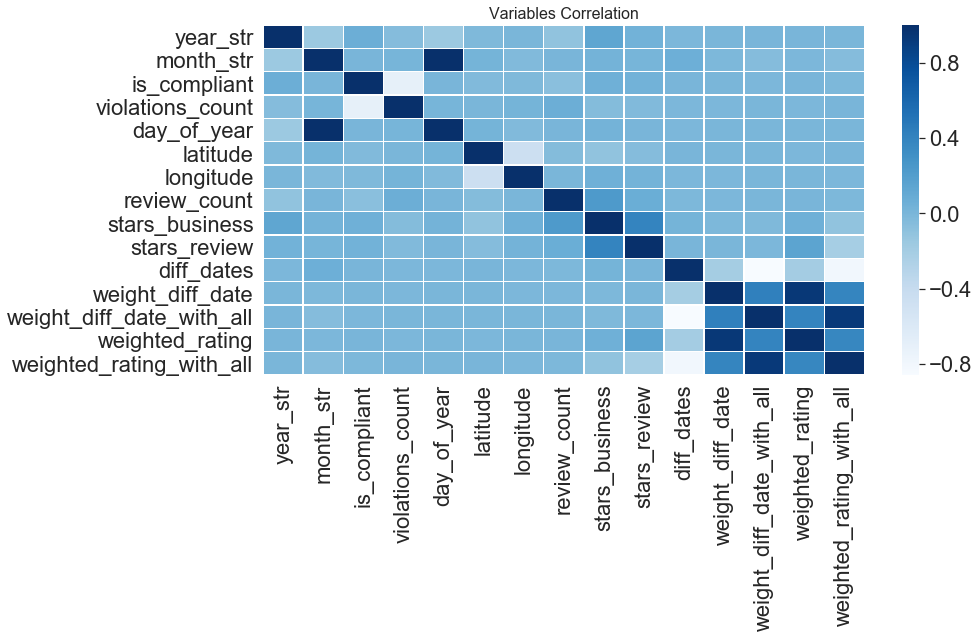

In [91]:
# calculate the correlation matrix
corr = results_short_no_dummies.corr()

# plot the heatmap
_=sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, linewidths=.5, cmap="Blues")
_=plt.title('Variables Correlation')

<a id='predictivemodels'></a>

# Predictive Models
<p>The goal of the following section is to compare the performance of two Logistic Regression models and two Random Forests models to predict non-compliant inspection results, using slightly different predictors.</p>
<p>The performance of the models was evaluated using both cross validation and confusion matrix to see how many inspection results were misclassified.</p>

### Target and Input Variables

* <b>Target Variable:</b><em> 'is_compliant'</em>. Binary, 0 and 1, specifying the inspection results.

##### Six Types of Predictors:

* Location and Customer ratings: <p>'zip_code', 'review_count', 'stars_business'</p>

* Cuisine and Establishment type:<p>'American (New)', 'American (Traditional)', 'Asian Fusion', 'Bar / Tavern', 'Breakfast & Brunch', 'Buffet', 'Cafes', 'Chinese', 'Delis', 'Desserts', 'Diners', 'Donuts', 'Ethnic Food', 'Fast Food', 'Food', 'Food Trucks / Mobile Vendor', 'Gluten-Free', 'Hawaiian', 'Health Markets', 'Indian', 'Italian', 'Japanese', 'Juice Bars & Smoothies', 'Kitchen Bakery', 'Latin American', 'Meat/Poultry/Seafood', 'Mediterranean', 'Mexican', 'Middle Eastern', 'Modern European', 'Restaurant', 'Sandwiches', 'Snack Bar', 'Spanish', 'Special Kitchen', 'Steakhouses', 'Taiwanese', 'Thai', 'Vegan', 'Venues & Event Spaces'</p>

* Inspection Type: <p>'inspection_type_Re-inspection', 'inspection_type_Routine Inspection', 'inspection_type_Survey'</p> 

* Inspection Day and Time: <p>'inspection_shift_morning', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday'</p>

* Inspection Month: <p>'month_str_2', 'month_str_3', 'month_str_4', 'month_str_5', 'month_str_6', 'month_str_7', 'month_str_8', 'month_str_9', 'month_str_10', 'month_str_11', 'month_str_12'</p>

* Points and Grade at Time of Inspection:<p>'current_demerits', 'current_grade_B', 'current_grade_C', 'current_grade_O', 'current_grade_X'</p>

<a id='logistic'></a>

## Logistic Regression

<p>Logistic regression is a classification algorithm used to estimate the probability of a categorical variable belonging to a specific class, in this case the probability of an inspection resulting in a non-compliance result.</p>

In [92]:
# print a list of all possible input variables
print(results_dummies.columns.to_list(),end = '')

['current_demerits', 'inspection_demerits', 'year_str', 'zip_code', 'is_compliant', 'violations_count', 'day_of_year', 'latitude', 'longitude', 'review_count', 'stars_business', 'stars_review', 'diff_dates', 'weight_diff_date', 'weight_diff_date_with_all', 'weighted_rating', 'weighted_rating_with_all', 'inspection_type_Epidemiological Investigation', 'inspection_type_Re-inspection', 'inspection_type_Routine Inspection', 'inspection_type_Survey', 'food_type_American (New)', 'food_type_American (Traditional)', 'food_type_Asian Fusion', 'food_type_Bar / Tavern', 'food_type_Breakfast & Brunch', 'food_type_Buffet', 'food_type_Cafes', 'food_type_Caterer', 'food_type_Chinese', 'food_type_Delis', 'food_type_Desserts', 'food_type_Diners', 'food_type_Donuts', 'food_type_Ethnic Food', 'food_type_Fast Food', 'food_type_Food', 'food_type_Food Trucks / Mobile Vendor', 'food_type_Gluten-Free', 'food_type_Hawaiian', 'food_type_Health Markets', 'food_type_Indian', 'food_type_Italian', 'food_type_Japane

In [94]:
# drop irrelevant of duplicate variables 
df = results_dummies.drop(['diff_dates','weight_diff_date','inspection_demerits','stars_review','food_type_Caterer',
                           'food_type_Public Services & Government','day_of_year', 'year_str', 'violations_count',
                           'season_spring', 'season_summer','longitude', 'latitude', 'season_fall',
                           'season_winter','weighted_rating_with_all','weight_diff_date_with_all'], axis = 1)

### Split the data into a training and test set

The dataset was randomly split into training and test set, with 75% of the data in the training set to fit the model and 25% to evaluate the accuracy on unseen data.

In [95]:
# split the data predictors and target
X= df.drop(['is_compliant'], axis=1)
y = (df.is_compliant)

# verify dataset dimensions
X.shape
print('Input Variables:\n')
print(X.columns.to_list(),end = '')

(35242, 75)

Input Variables:

['current_demerits', 'zip_code', 'review_count', 'stars_business', 'weighted_rating', 'inspection_type_Epidemiological Investigation', 'inspection_type_Re-inspection', 'inspection_type_Routine Inspection', 'inspection_type_Survey', 'food_type_American (New)', 'food_type_American (Traditional)', 'food_type_Asian Fusion', 'food_type_Bar / Tavern', 'food_type_Breakfast & Brunch', 'food_type_Buffet', 'food_type_Cafes', 'food_type_Chinese', 'food_type_Delis', 'food_type_Desserts', 'food_type_Diners', 'food_type_Donuts', 'food_type_Ethnic Food', 'food_type_Fast Food', 'food_type_Food', 'food_type_Food Trucks / Mobile Vendor', 'food_type_Gluten-Free', 'food_type_Hawaiian', 'food_type_Health Markets', 'food_type_Indian', 'food_type_Italian', 'food_type_Japanese', 'food_type_Juice Bars & Smoothies', 'food_type_Kitchen Bakery', 'food_type_Latin American', 'food_type_Meat/Poultry/Seafood', 'food_type_Mediterranean', 'food_type_Mexican', 'food_type_Middle Eastern', 'food_type_Mod

In [96]:
np.random.seed(44)
# Split the data into a training and test set.
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,random_state=5,test_size=0.25)

### First Logistic Regression
The first model uses accuracy to score the model's performance and a 5-fold cross-validation

In [97]:
# instantiate the logistic regression model
clf = LogisticRegression(solver = 'lbfgs',max_iter=4000)

# set the para-grid as a dictionary
c_params = {'C': [0.01,0.1, 1, 10, 100]}

# use GridSearchCV to find the best C value a list of values and 5-fold crossvalidation
clf_best = GridSearchCV(clf, param_grid=c_params, cv = 5, scoring = 'accuracy')

# fit the model on train data
_=clf_best.fit(Xtrain,ytrain)

# test the model on unseen data
ypred = clf_best.predict(Xtest)

#### Model's Accuracy

In [98]:
# Measure Model's Accuracy on Unseen data
ypred = clf_best.predict(Xtest)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(clf_best.score(Xtest, ytest)))
print('\nClassification report:')
print(classification_report(ytest, ypred))

Accuracy of logistic regression classifier on test set: 0.7588

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2125
           1       0.76      1.00      0.86      6686

   micro avg       0.76      0.76      0.76      8811
   macro avg       0.38      0.50      0.43      8811
weighted avg       0.58      0.76      0.65      8811



/Users/geovannameier/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/geovannameier/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/geovannameier/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Although the accuracy of the the model is 76% on the test set, the model failed to classify any of the non-compliant results, recognizing only the positive results. 

### Second Logistic Regression

A second logistic regression model was tried setting the class_weight parameter to 'balanced', to see if the model will improve.  Based on the LogisticRegression documentation: 
    <p style="text-align:center">“The "balanced" mode uses the values of y to automatically adjust
    weights inversely proportional to class frequencies in the input data
    as</p> <p style="text-align:center">``n_samples / (n_classes * np.bincount(y))``.”</p>

### Fit Model and Evaluate Accuracy

In [99]:
# instantiate the logistic regression model
lr_model = LogisticRegression(solver = 'lbfgs', class_weight='balanced',max_iter=4000)

# set the para-grid as a dictionary
c_params = {'C': [0.01,0.1, 1, 10, 100]}

# use GridSearchCV to find the best C value using Cs list for the param_grid argument and 5-fold crossvalidation
best_model = GridSearchCV(lr_model, param_grid=c_params, cv = 6, scoring = 'accuracy')

# fit the model on train data
_=best_model.fit(Xtrain,ytrain)

# test the model on unseen data
pred = best_model.predict(Xtest)

# print accuracy score and the c value used
print("Accuracy score Linear Regression Model:%.3f\nBest parameter: %s"%(accuracy_score(pred, ytest), best_model.best_params_))
print('\nClassification Report Logistic Regression')
print(classification_report(ytest, pred))

Accuracy score Linear Regression Model:0.585
Best parameter: {'C': 1}

Classification Report Logistic Regression
              precision    recall  f1-score   support

           0       0.35      0.81      0.48      2125
           1       0.89      0.51      0.65      6686

   micro avg       0.58      0.58      0.58      8811
   macro avg       0.62      0.66      0.57      8811
weighted avg       0.76      0.58      0.61      8811



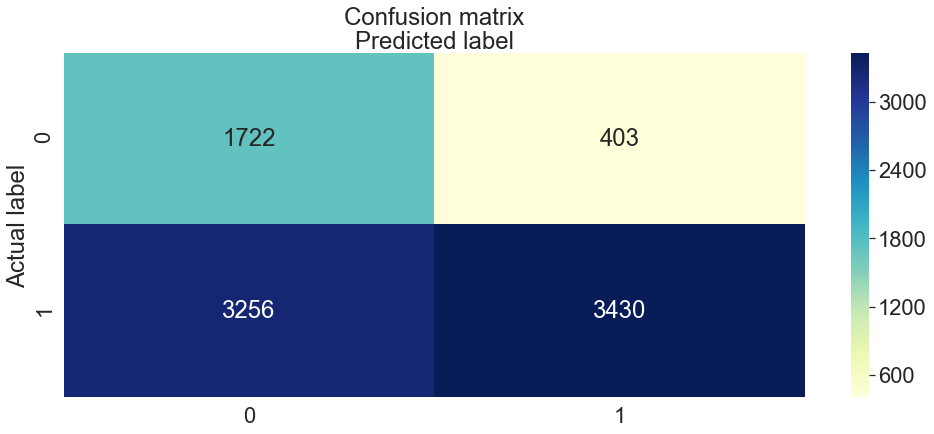

In [100]:
# test accuracy using confusion matrix
cnf_matrix = metrics.confusion_matrix(ytest, pred)

plt.rcParams['figure.figsize'] = [14,6]
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
sns.set_style(style = 'dark')


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
_=plt.xticks(tick_marks, class_names)
_=plt.yticks(tick_marks, class_names)

# create heatmap
_=sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
_=ax.xaxis.set_label_position("top")
_=plt.tight_layout()
_=plt.title('Confusion matrix', y=1.1)
_=plt.ylabel('Actual label')
_=plt.xlabel('Predicted label')

<p>Although the predictive accuracy of the non-compliance results improved, the model did not perform well classifying the compliance results. It was able to accurately identify 81% of the non-compliance results, but only 51% of compliance results.</p>

<a id='randomforest'></a>

****
## Random Forests
<p>Random forests fit several Decision Trees with a random set of attributes each and averages the predicitons to find the 'best' model.</p><p>The first random forest was trained using the same variables and training set used by the Logistic Regression and setting the minimum number of samples required to split an internal node to 50.</p>

### Random Forest Splits=50
<p>The first random forest uses the same input variables as the logistic regression model and the same training and testing sets.</p>

In [101]:
np.random.seed(44)
#Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=5)

#Train the model using the training sets y_pred=clf.predict(X_test)
_=rf.fit(Xtrain,ytrain)

pred_rf=rf.predict(Xtest)

#### Accuracy on Test Set

In [102]:
# Model Accuracy
print("Accuracy score Random Forest (splits=50): ",metrics.accuracy_score(ytest, pred_rf))
print('\nClassification Report Random Forest')
print(classification_report(ytest, pred_rf))

Accuracy score Random Forest (splits=50):  0.8656225173079106

Classification Report Random Forest
              precision    recall  f1-score   support

           0       0.94      0.47      0.63      2125
           1       0.86      0.99      0.92      6686

   micro avg       0.87      0.87      0.87      8811
   macro avg       0.90      0.73      0.77      8811
weighted avg       0.88      0.87      0.85      8811



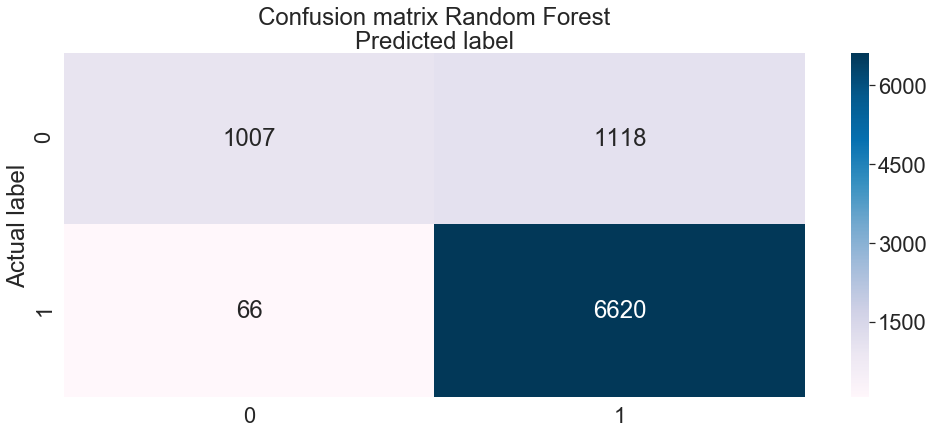

In [103]:

rf_matrix = metrics.confusion_matrix(ytest, pred_rf)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
_=plt.xticks(tick_marks, class_names)
_=plt.yticks(tick_marks, class_names)

# create heatmap
_=sns.heatmap(pd.DataFrame(rf_matrix), annot=True, cmap="PuBu" ,fmt='g')
_=ax.xaxis.set_label_position("top")
_=plt.tight_layout()
_=plt.title('Confusion matrix Random Forest', y=1.1)
_=plt.ylabel('Actual label')
_=plt.xlabel('Predicted label')

<p>The accuracy score and the classification resports, show that even though the Random Forest performed better than the basic Logistic Regression, obtaining an 87% accuracy, it only identified 47% of the true non-compliant results. Thus, using these parameters and 75% of the data to train the model, this model did not provide betteer results than randomly guessing the outcome of an inspection.</p>

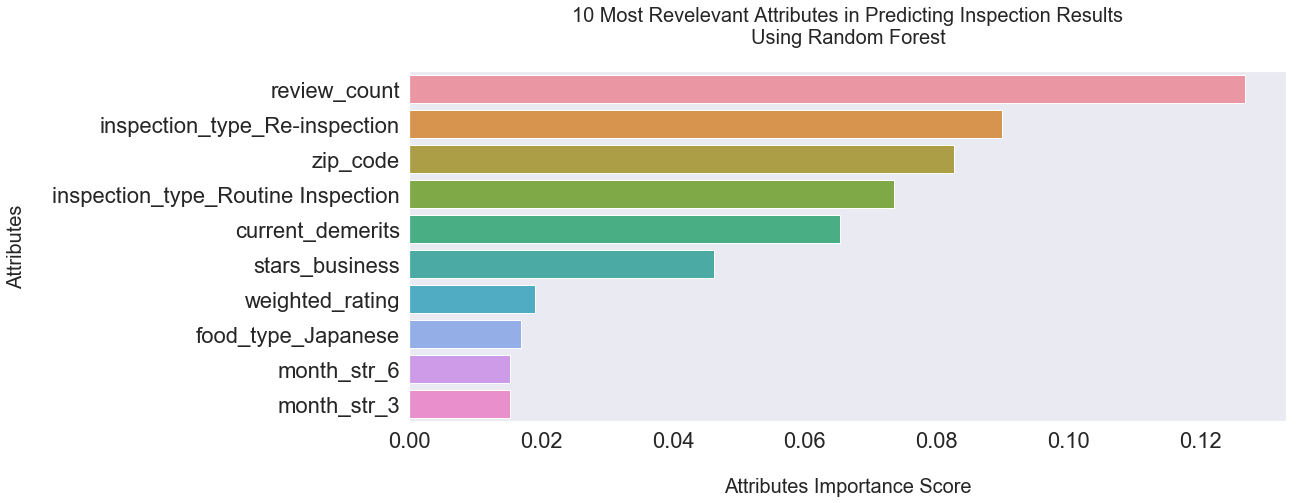

In [104]:
# set random seed to replicate results
np.random.seed(44)

# get variable names
model_vars = X.columns.to_list()

# create a data frame with variables importance and their score
feature_imp = pd.Series(rf.feature_importances_,index=model_vars).sort_values(ascending=False)

# plot 10 most relevant variables
_=sns.barplot(x=feature_imp[:10], y=feature_imp.index[:10])
_=plt.title('10 Most Revelevant Attributes in Predicting Inspection Results\nUsing Random Forest\n', fontsize = 20)
_=plt.xlabel('\nAttributes Importance Score', fontsize = 20)
_=plt.ylabel('Attributes\n', fontsize = 20)

***
## Random Forest Splits=20

In [105]:
# drop duplicates and variables that are not meaningful
df = results_dummies.drop(['diff_dates','weight_diff_date','inspection_demerits',
                           'food_type_Public Services & Government','stars_review','season_fall',
                           'day_of_year', 'year_str', 'violations_count','weighted_rating','longitude', 'latitude',
                           'weighted_rating_with_all','weight_diff_date_with_all','season_spring', 'season_summer', 'season_winter'], axis = 1)

In [106]:
# split the data into trainin and testing sets
X= df.drop(['is_compliant'], axis=1)
y = (df.is_compliant)

In [107]:
print('Input Variables Random Forest:')
print(X.columns.to_list(),end = '')

Input Variables Random Forest:
['current_demerits', 'zip_code', 'review_count', 'stars_business', 'inspection_type_Epidemiological Investigation', 'inspection_type_Re-inspection', 'inspection_type_Routine Inspection', 'inspection_type_Survey', 'food_type_American (New)', 'food_type_American (Traditional)', 'food_type_Asian Fusion', 'food_type_Bar / Tavern', 'food_type_Breakfast & Brunch', 'food_type_Buffet', 'food_type_Cafes', 'food_type_Caterer', 'food_type_Chinese', 'food_type_Delis', 'food_type_Desserts', 'food_type_Diners', 'food_type_Donuts', 'food_type_Ethnic Food', 'food_type_Fast Food', 'food_type_Food', 'food_type_Food Trucks / Mobile Vendor', 'food_type_Gluten-Free', 'food_type_Hawaiian', 'food_type_Health Markets', 'food_type_Indian', 'food_type_Italian', 'food_type_Japanese', 'food_type_Juice Bars & Smoothies', 'food_type_Kitchen Bakery', 'food_type_Latin American', 'food_type_Meat/Poultry/Seafood', 'food_type_Mediterranean', 'food_type_Mexican', 'food_type_Middle Eastern',

In [108]:
# set random seed
np.random.seed(44)
# Split the data into a training and test set.
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,random_state=5,test_size=0.25)

### Fit Model

In [109]:
#Create a Gaussian Classifier
rf2=RandomForestClassifier(n_estimators=250, min_samples_split=20, random_state=5)

#Train the model using the training sets y_pred=clf.predict(X_test)
_=rf2.fit(Xtrain,ytrain)

# test the model on unseen data
pred_rf2=rf2.predict(Xtest)

### Test Accuracy

In [110]:
print("Accuracy score Random Forest (splits=20):",metrics.accuracy_score(ytest, pred_rf2))
print('\nClassification Report Random Forest (splits=20)')
print(classification_report(ytest, pred_rf2))

Accuracy score Random Forest (splits=20): 0.9247531494722506

Classification Report Random Forest (splits=20)
              precision    recall  f1-score   support

           0       0.96      0.71      0.82      2125
           1       0.92      0.99      0.95      6686

   micro avg       0.92      0.92      0.92      8811
   macro avg       0.94      0.85      0.89      8811
weighted avg       0.93      0.92      0.92      8811



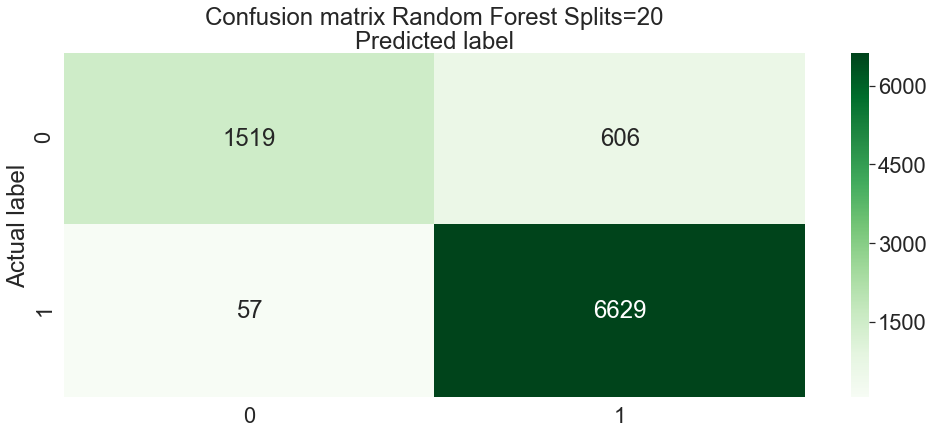

In [111]:
# create confusion matrix
rf2_matrix = metrics.confusion_matrix(ytest, pred_rf2)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
_=plt.xticks(tick_marks, class_names)
_=plt.yticks(tick_marks, class_names)

# create heatmap
_=sns.heatmap(pd.DataFrame(rf2_matrix), annot=True, cmap="Greens" ,fmt='g')
_=ax.xaxis.set_label_position("top")
_=plt.tight_layout()
_=plt.title('Confusion matrix Random Forest Splits=20', y=1.1)
_=plt.ylabel('Actual label')
_=plt.xlabel('Predicted label')

In [112]:
training_accuracy_rf2 = rf2.score(Xtrain, ytrain)
test_accuracy_rf2 = rf2.score(Xtest, ytest)
print('Accuracy on training set:', training_accuracy_rf2)
print('Accuracy on test set:', test_accuracy_rf2)

Accuracy on training set: 0.9513828459006469
Accuracy on test set: 0.9247531494722506


In [113]:
# get variable names
model_vars_rf2 = X.columns.to_list()

# plot variable importance
feature_imp_rf2 = pd.Series(rf2.feature_importances_,index=model_vars_rf2).sort_values(ascending=False)

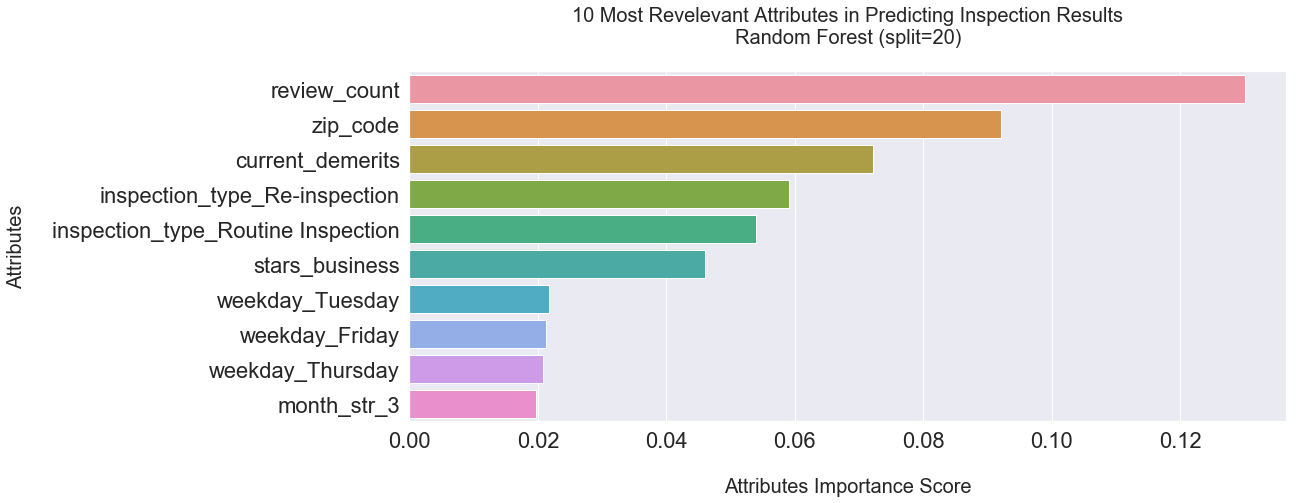

In [114]:
plt.style.use('Solarize_Light2')
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
sns.set_style(style = 'darkgrid')
_=sns.barplot(x=feature_imp_rf2[:10], y=feature_imp_rf2.index[:10])
_=plt.title('10 Most Revelevant Attributes in Predicting Inspection Results\nRandom Forest (split=20)\n', fontsize = 20)
_=plt.xlabel('\nAttributes Importance Score', fontsize = 20)
_=plt.ylabel('Attributes\n', fontsize = 20)

<p>A second random forest was trained, this time using a minimum of 20 samples to split an internal node, and setting the number of decision trees to be trained to 250. The overall performance of the model increased 6% over the the previous random forest to 92% and the recall of non-compliance results improved to 71% from 46% obtained with the previous random forest. This means that this model can accurately identify 71% of non-compliance results.</p>
<p>The model estimates that one of the most relevant factors in predicting inspection results is the number of reviews the establishment receives. This suggests, that in general, popular establishments tend to be in good condition and comply with health and safety standards.</p>
<p>Location was also considered to be a relevant predictor. According to the model, the area where the restaurant is located can have an impact on the inspection results. This predictor could be further analyze to show if busier and most touristic zip codes tend to have lower or higher compliance rates.</p>
<p>The current demerits, or violations points at the time of the inspection, was also found to be a relevant predictors. This indicates that establishments who have a good compliance record tend to maintain good health and safety conditions.</p>

<a id='conclusions'></a>

***

# Results and Conclusions
<p>The previous analysis used publicly available data on inspection results and social media data on business attributes and customer ratings, to help predict food and safety violations and improve inspection visits by prioritizing establishments that are likely to have a non-compliance result.</p>
<p>Since the hypothesis was that details such as type, date and time of inspection, along with business’ attributes such as cuisine type, star rating and number of reviews would have an impact on inspection results, feature engineering was key component of the analysis to obtain individual features such as inspection shift, season, time between inspection and customer ratings, and weighted star ratings.</p>

### Predictive model
<p>Several combination of features were tried before selecting the ‘best model’ as it wasn’t clear what features would add value or decrease performance. For the last Random Forest, which provided the best performance, removing star ratings, along with season, year of inspection, and the violation counts as these won’t be available until the inspection is completed, provided the highest accuracy when predicting inspection results.</p>
<p>The Random Forest found that the most relevant set of predictors of compliance are related to inspection details, such as the type, day, time, and location of the inspection and less with the type of cuisine or the specific rating given by users on a given day, but instead the overall number of reviews and the business rating.</p>

### Further Analysis
<p>Two of the variables used in early models that were considered very relevant by the logistic regression and random forest algorithms were the violations counts and the year of the inspection. Since these feature are based on the actual inspection, they were omitted. However, future analysis could consider the year when the establishment was opened and the number of violations found during the last inspection. The former could provide information on whether compliance is significantly different between established and new businesses, and the latter could indicate the areas where businesses continuously struggle.</p>
